In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20756'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1024'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_1'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_B1H_Inst_20608'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_8_B1H_Inst_252'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_16_8_stride_4_B1H_Inst_253'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_8_strid

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_center_scale_100_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

Mar/01 16:56:50 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Mar/01 16:56:50 pyobsbox.generator INFO: shuffle: True
Mar/01 16:56:50 pyobsbox.generator INFO: seed: 42
Mar/01 16:56:50 pyobsbox.generator INFO: batch_size: 8192
Mar/01 16:56:50 pyobsbox.generator INFO: sequence_length: 2048
Mar/01 16:56:50 pyobsbox.generator INFO: n_bunches: 256
Mar/01 16:56:50 pyobsbox.generator INFO: __len__: 1035
Mar/01 16:56:50 pyobsbox.generator INFO: fetched_log_folder: None
Mar/01 16:56:50 pyobsbox.generator INFO: fetched_log_prefix: 
Mar/01 16:56:50 pyobsbox.generator INFO: normalization: center_scale
Mar/01 16:56:50 pyobsbox.generator INFO: normalization_pre_split: False
Mar/01 16:56:50 pyobsbox.generator INFO: normalization_kwargs: {'scale_factor': 100}
Mar/01 16:56:50 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Mar/01 16:56:50 pyobsbox.

In [9]:
print(train_metadata.shape)
train_metadata.head()

(264960, 11)


type  fill  beam plane  q           date_time  \
7245798  Inst  6581     1     h  7 2018-04-20 17:22:14   
6889114  Inst  6703     1     h  7 2018-05-20 03:39:14   
1617574  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141640  Inst  7466     1     h  7 2018-11-22 20:57:15   
593476   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245798  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6581/...         84   
6889114  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6703/...        396   
1617574  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141640  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/...        670   
593476   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245798        143.0          53.0      65536  
6889114        533.0         368.0      65536  
1617574       1588.0        1163.0      65536  
6141640       2491.0         528.0      65536  
593476        1980.0        1083.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
9286385  Inst  6348     1     h  7 2017-10-31 00:44:14   
1728450  Inst  7486     1     h  7 2018-11-30 08:25:16   
6036402  Inst  7451     1     h  7 2018-11-17 13:38:33   
9949186  Inst  6348     1     h  7 2017-10-30 21:51:14   
933629   Inst  7122     1     h  7 2018-09-03 09:00:15   

                                                      file  n_bunches  \
9286385  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/...       1868   
1728450  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7486/...        418   
6036402  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7451/...        372   
9949186  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/...       1868   
933629   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7122/...       2556   

         bunch_index  bunch_number  ts_length  
9286385       2016.0        1082.0      65536  
1728450        521.0         109.0      65536  
6036402        495.0          89.0      65536  
9949186       2804.0        1494.0      65536  
933629         777.0         551.0      65536

# Loss functions

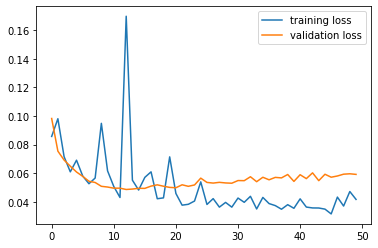

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(409600, 2048, 1)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(40960, 2048, 1)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 59s 1s/step


(409600, 2048, 1)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 970ms/step


(40960, 2048, 1)

In [16]:
MAE_train = abs(train_pred - train_dataset).mean(axis=1).squeeze()
MAE_train.shape

(409600,)

In [17]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=1).squeeze()
MAE_validation.shape

(40960,)

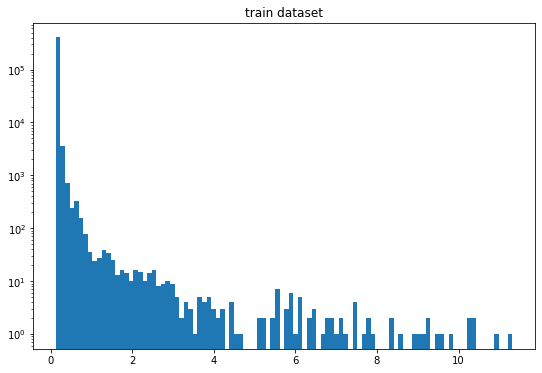

In [58]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [19]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.13114125258711284

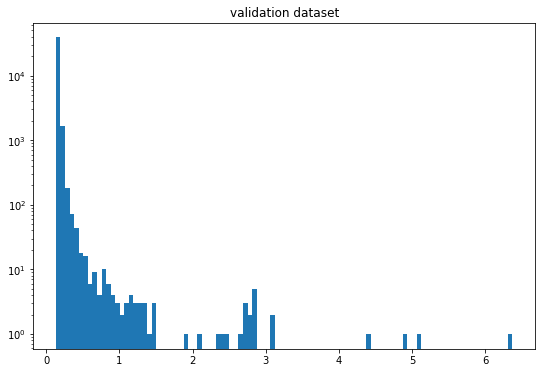

In [20]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [21]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.13258117613069773

In [22]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [23]:
max_MAE_indices

array([ 74178,  78742, 224626, ...,   4368, 394893,  59832])

In [24]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal)
    axes[0].plot(pred_signal)

    axes[1].plot(np.abs(np.diff(true_signal)))
    axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  74178
MAE:  11.319369574327139
n_bunches       1227
bunch_index     1138
bunch_number     402
Name: 6018714, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_06h04m14s.h5


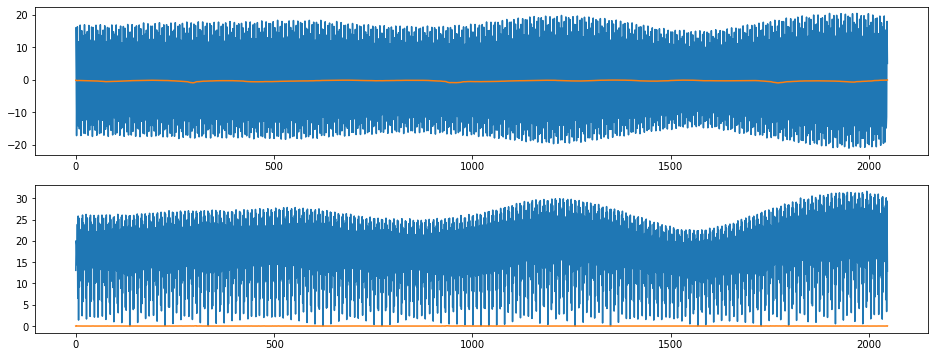

In [25]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  74178
MAE:  11.319369574327139
n_bunches       1227
bunch_index     1138
bunch_number     402
Name: 6018714, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_06h04m14s.h5


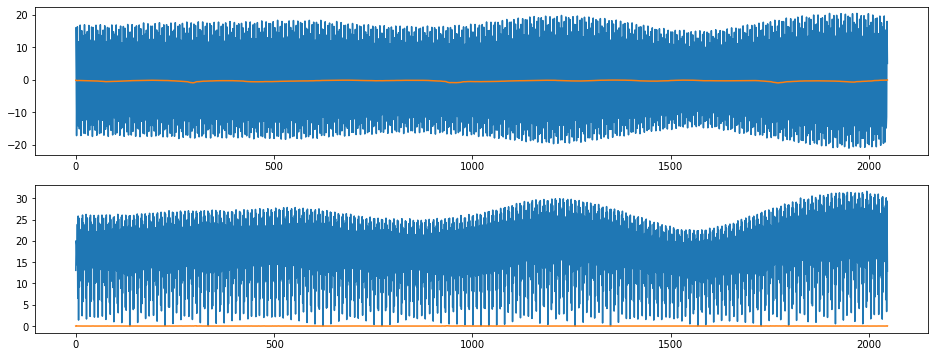

index:  78742
MAE:  10.919078901822068
n_bunches       1868
bunch_index      518
bunch_number     281
Name: 4111950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_12h03m14s.h5


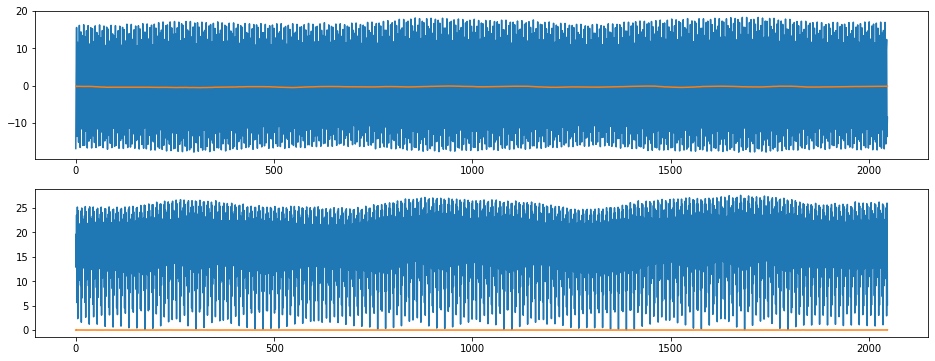

index:  224626
MAE:  10.342563704146487
n_bunches       1916
bunch_index      494
bunch_number     268
Name: 1169867, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_08h47m15s.h5


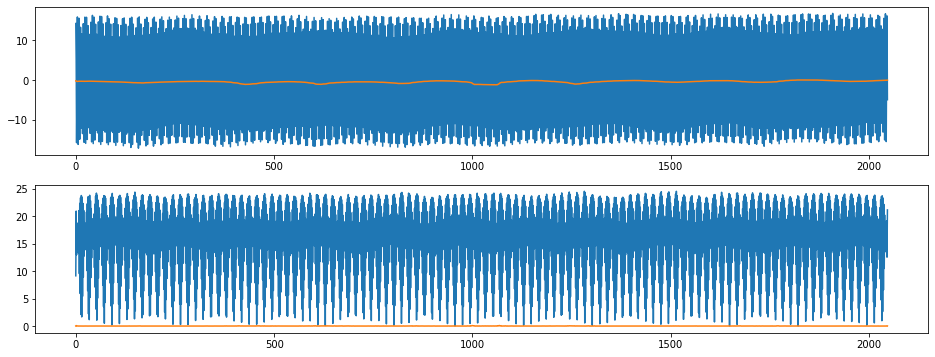

index:  74917
MAE:  10.328164314693204
n_bunches       1868
bunch_index      474
bunch_number     252
Name: 309793, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6355/instability_data/06355_Inst_B1H_Q7_20171101_19h27m14s.h5


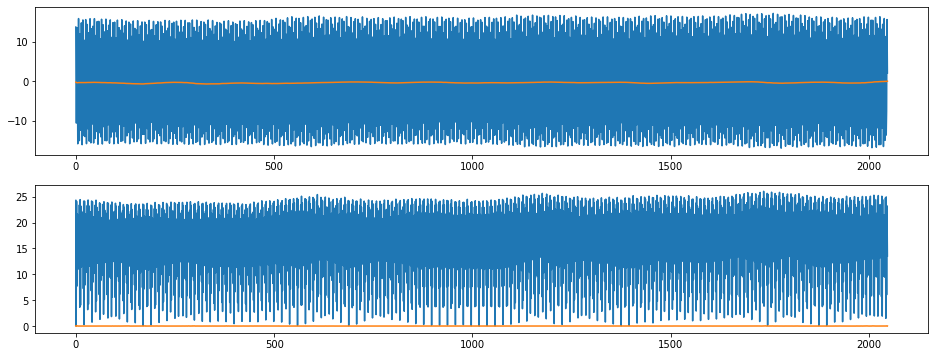

index:  77525
MAE:  10.239005779985455
n_bunches       336
bunch_index     151
bunch_number     24
Name: 2863291, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/instability_data/07443_Inst_B1H_Q7_20181114_03h46m14s.h5


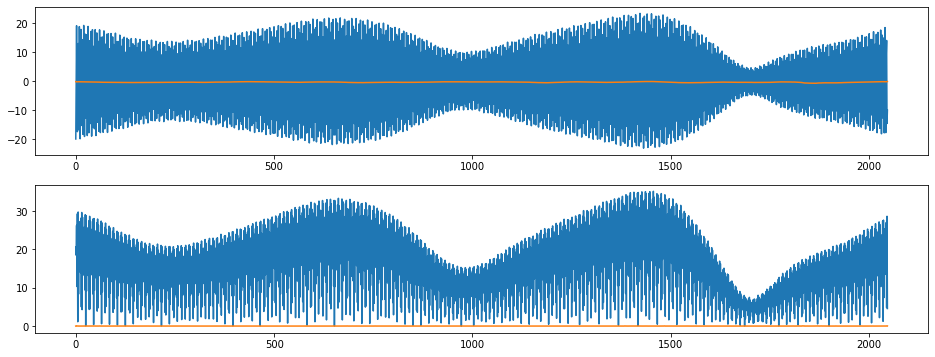

index:  221778
MAE:  10.23599762395661
n_bunches       1868
bunch_index        1
bunch_number       1
Name: 3803100, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6370/instability_data/06370_Inst_B1H_Q7_20171109_04h30m14s.h5


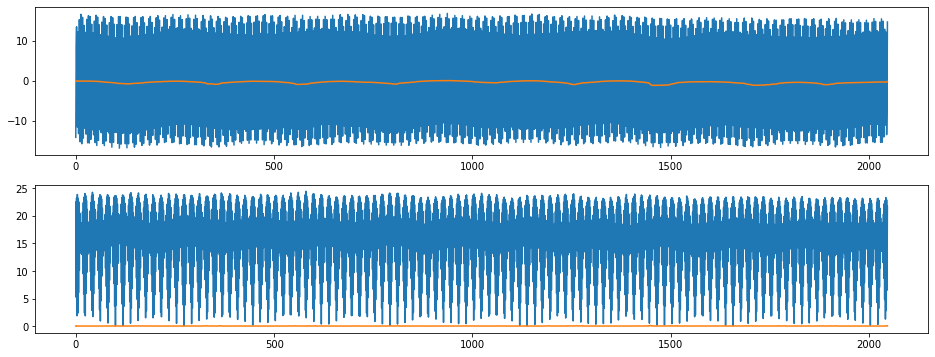

index:  221326
MAE:  9.823305588116746
n_bunches       652
bunch_index     402
bunch_number    207
Name: 1695976, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6355/instability_data/06355_Inst_B1H_Q7_20171101_18h21m18s.h5


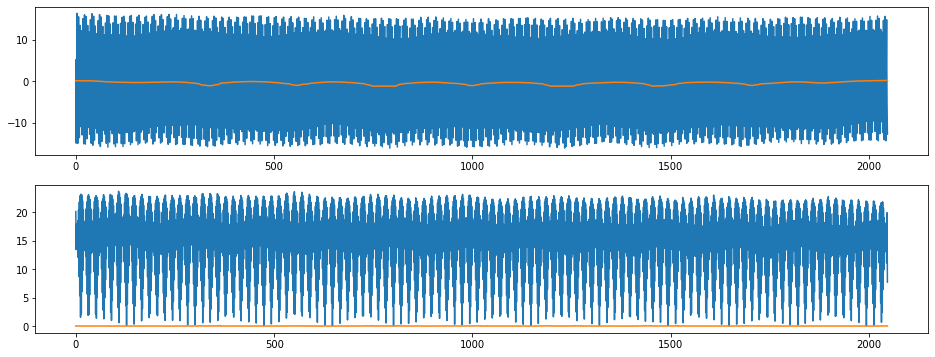

index:  78036
MAE:  9.547472524700861
n_bunches        376
bunch_index     1630
bunch_number     346
Name: 8739639, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_17h55m16s.h5


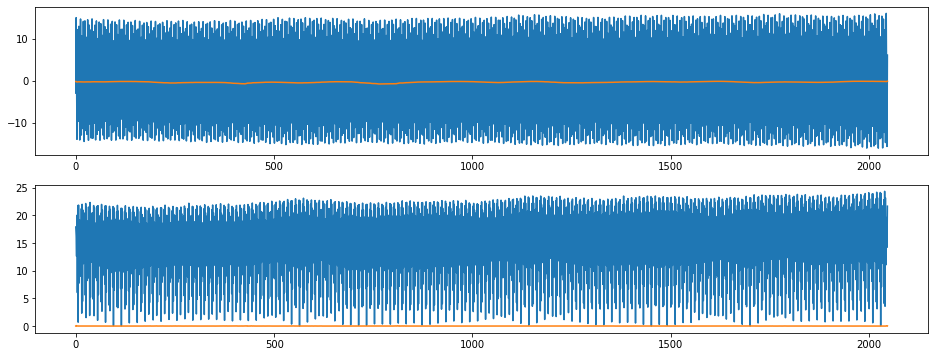

index:  1304
MAE:  9.420575242010237
n_bunches       2556
bunch_index      127
bunch_number      71
Name: 4666402, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180807_00h17m15s.h5


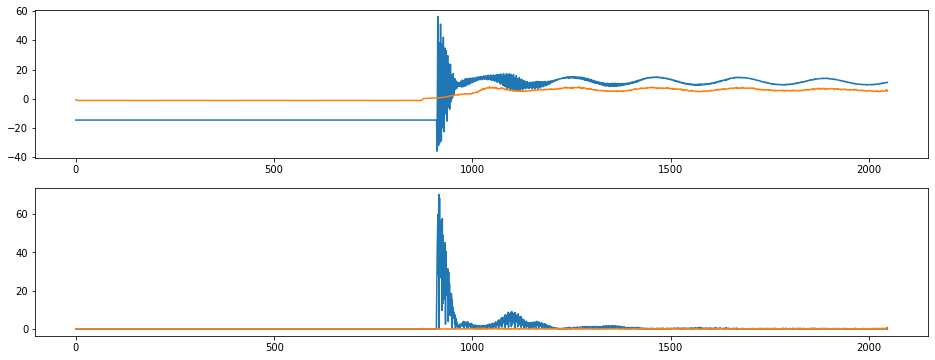

index:  268696
MAE:  9.25528207731848
n_bunches       2175
bunch_index     2840
bunch_number    1827
Name: 7711481, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_11h56m13s.h5


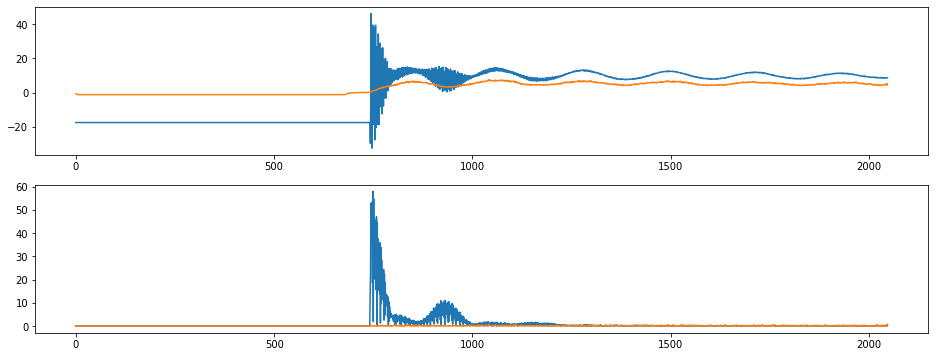

In [26]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  59832
MAE:  0.13114125258711284
n_bunches       396
bunch_index     251
bunch_number    145
Name: 8254716, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6677/instability_data/06677_Inst_B1H_Q7_20180513_12h54m58s.h5


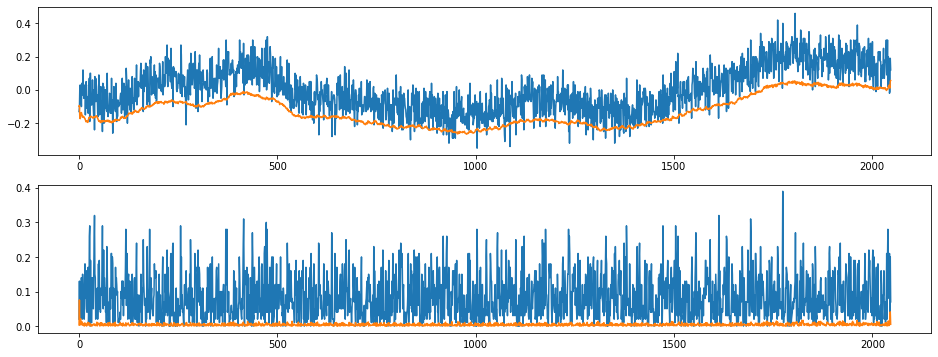

index:  394893
MAE:  0.13166002993275472
n_bunches       396
bunch_index     507
bunch_number    361
Name: 6777879, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7056/instability_data/07056_Inst_B1H_Q7_20180815_02h59m13s.h5


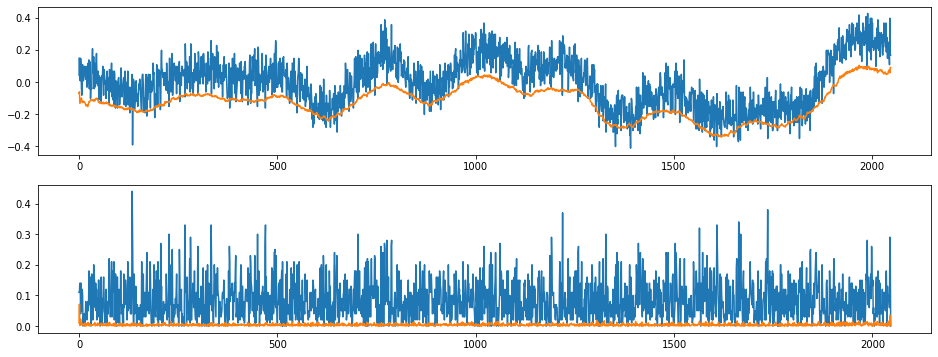

index:  4368
MAE:  0.13184286649298882
n_bunches       924
bunch_index     941
bunch_number    677
Name: 3159440, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h15m19s.h5


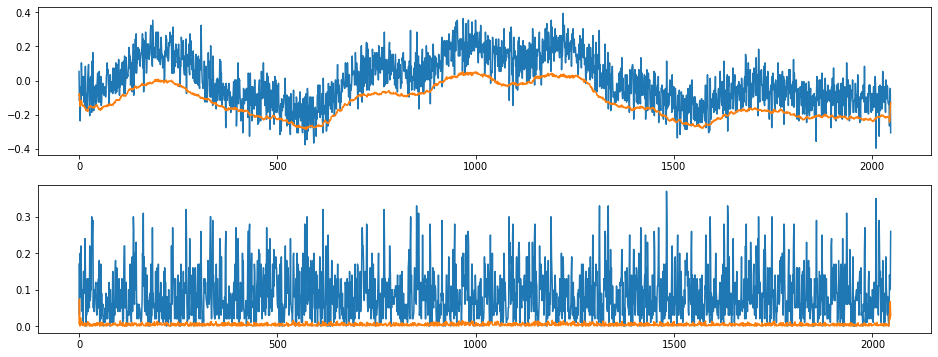

index:  85934
MAE:  0.1319180673707524
n_bunches       157
bunch_index     305
bunch_number     83
Name: 7141483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6435/instability_data/06435_Inst_B1H_Q7_20171129_19h57m13s.h5


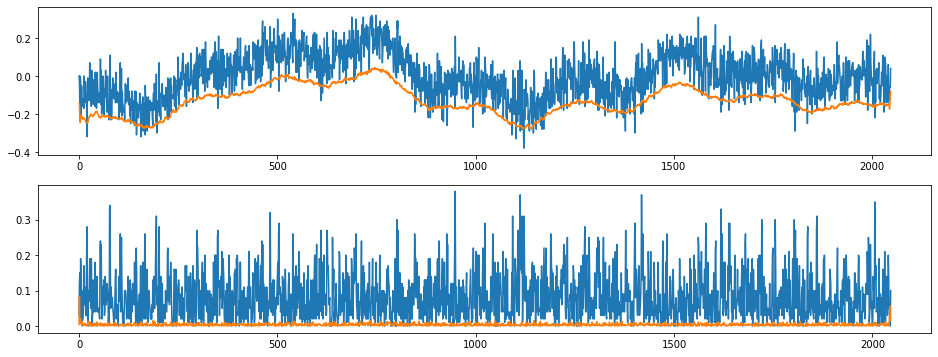

index:  147244
MAE:  0.1320874760057268
n_bunches       1868
bunch_index     3423
bunch_number    1852
Name: 10621317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_06h08m14s.h5


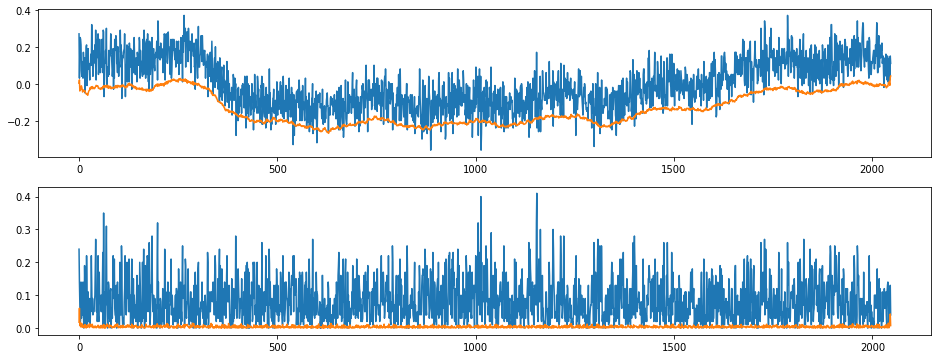

index:  367
MAE:  0.1321555714356873
n_bunches        684
bunch_index     1081
bunch_number     582
Name: 3496756, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m14s.h5


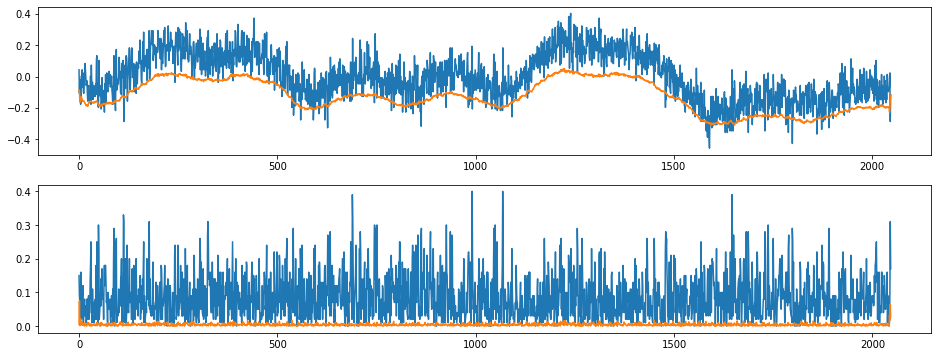

index:  147035
MAE:  0.13227418601622049
n_bunches       1868
bunch_index     3337
bunch_number    1800
Name: 8374461, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_09h56m14s.h5


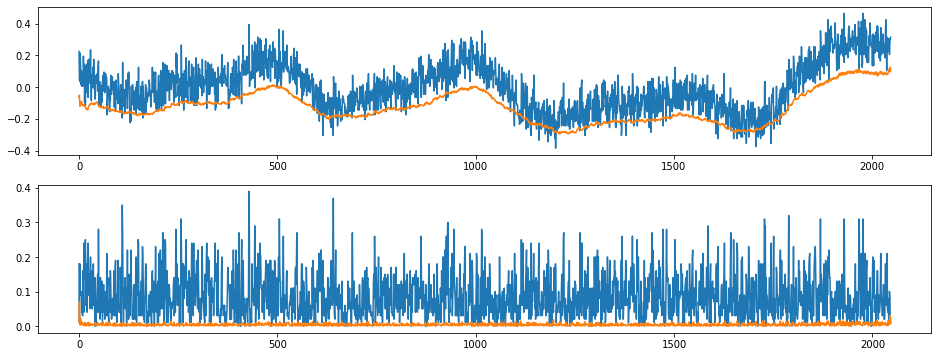

index:  379486
MAE:  0.132294425202781
n_bunches        780
bunch_index     1023
bunch_number     745
Name: 5789258, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h45m18s.h5


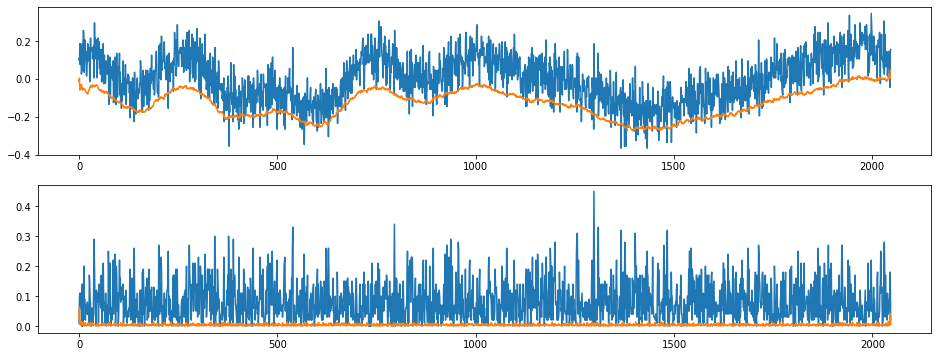

index:  242856
MAE:  0.13242492229172056
n_bunches        782
bunch_index     1173
bunch_number     519
Name: 7496323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6627/instability_data/06627_Inst_B1H_Q7_20180430_18h58m08s.h5


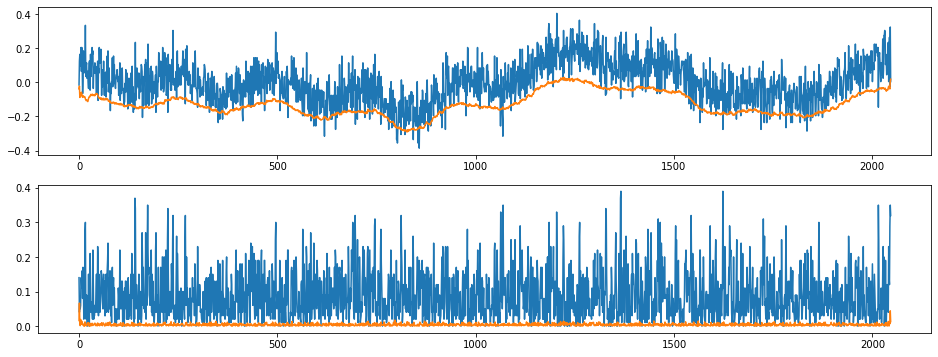

index:  397025
MAE:  0.13251978242176846
n_bunches       2556
bunch_index      446
bunch_number     295
Name: 11648045, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_15h31m14s.h5


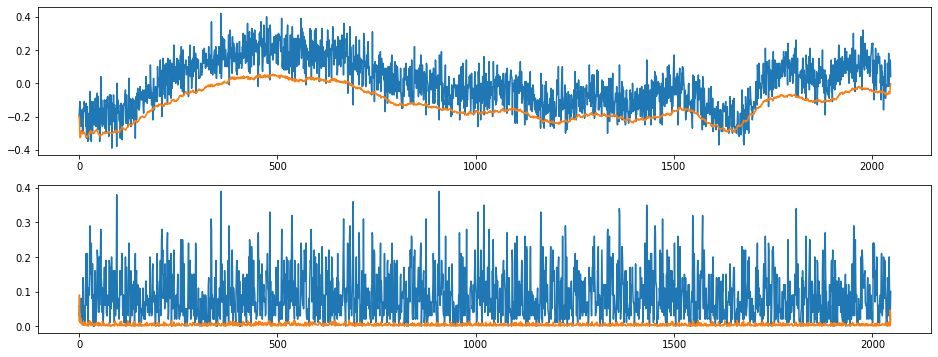

In [27]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [28]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  59832
MAE:  0.13114125258711284
n_bunches       396
bunch_index     251
bunch_number    145
Name: 8254716, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6677/instability_data/06677_Inst_B1H_Q7_20180513_12h54m58s.h5


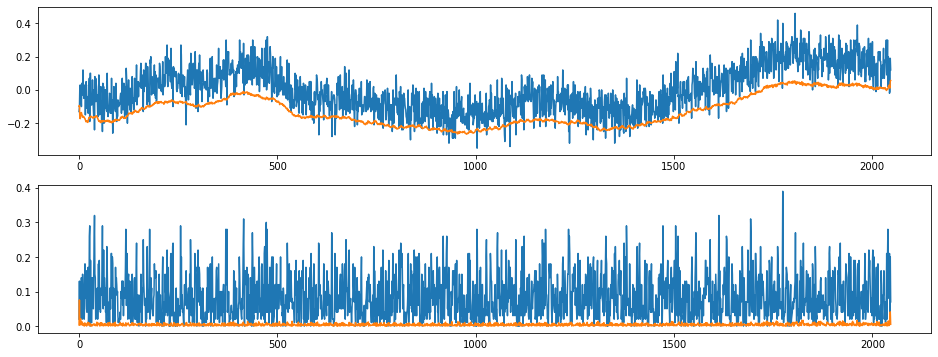

index:  394893
MAE:  0.13166002993275472
n_bunches       396
bunch_index     507
bunch_number    361
Name: 6777879, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7056/instability_data/07056_Inst_B1H_Q7_20180815_02h59m13s.h5


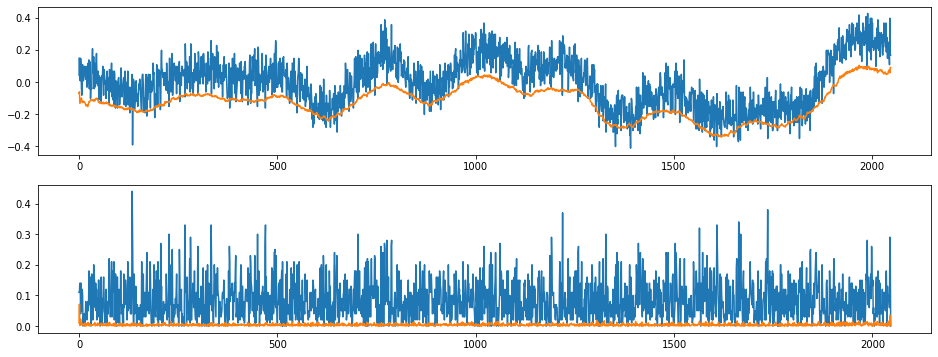

index:  4368
MAE:  0.13184286649298882
n_bunches       924
bunch_index     941
bunch_number    677
Name: 3159440, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h15m19s.h5


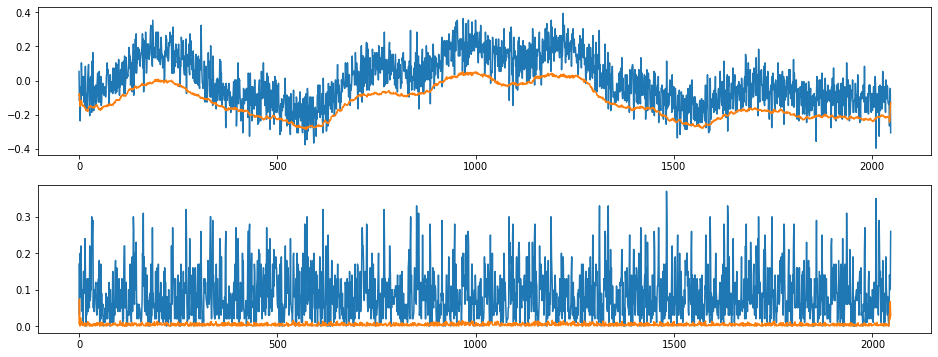

index:  85934
MAE:  0.1319180673707524
n_bunches       157
bunch_index     305
bunch_number     83
Name: 7141483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6435/instability_data/06435_Inst_B1H_Q7_20171129_19h57m13s.h5


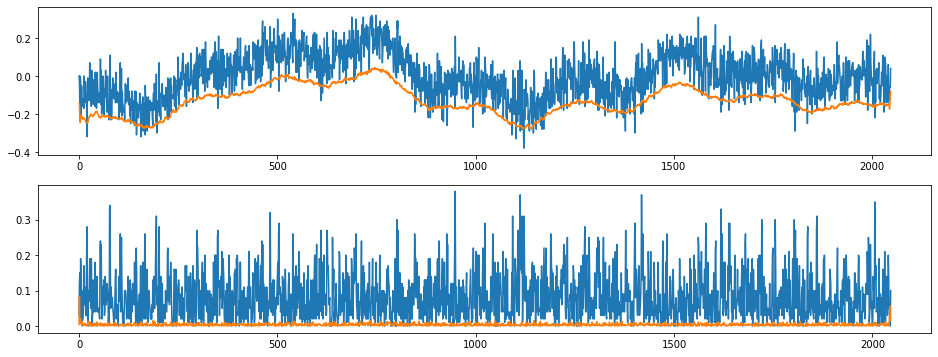

index:  147244
MAE:  0.1320874760057268
n_bunches       1868
bunch_index     3423
bunch_number    1852
Name: 10621317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_06h08m14s.h5


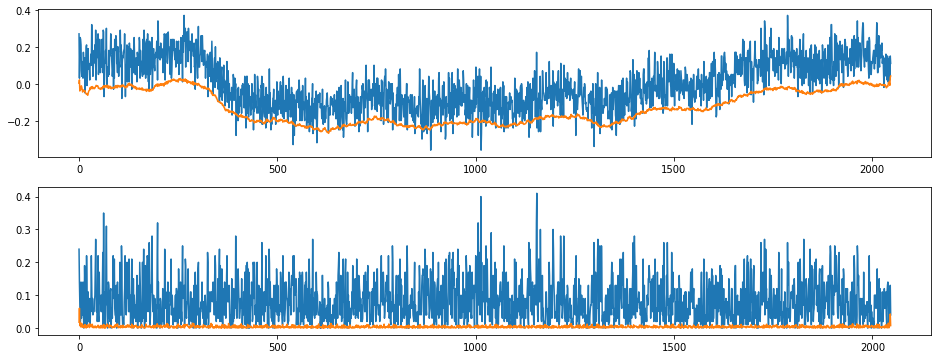

index:  367
MAE:  0.1321555714356873
n_bunches        684
bunch_index     1081
bunch_number     582
Name: 3496756, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m14s.h5


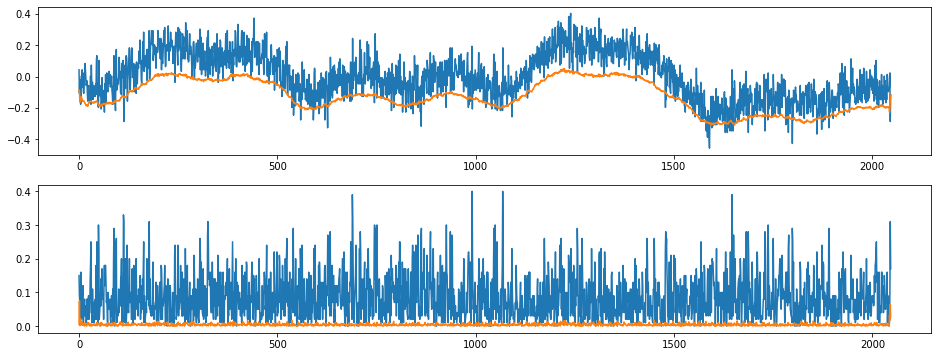

index:  147035
MAE:  0.13227418601622049
n_bunches       1868
bunch_index     3337
bunch_number    1800
Name: 8374461, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_09h56m14s.h5


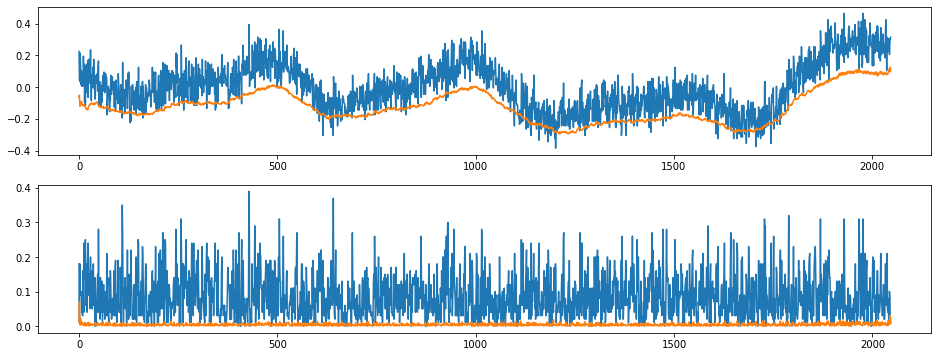

index:  379486
MAE:  0.132294425202781
n_bunches        780
bunch_index     1023
bunch_number     745
Name: 5789258, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h45m18s.h5


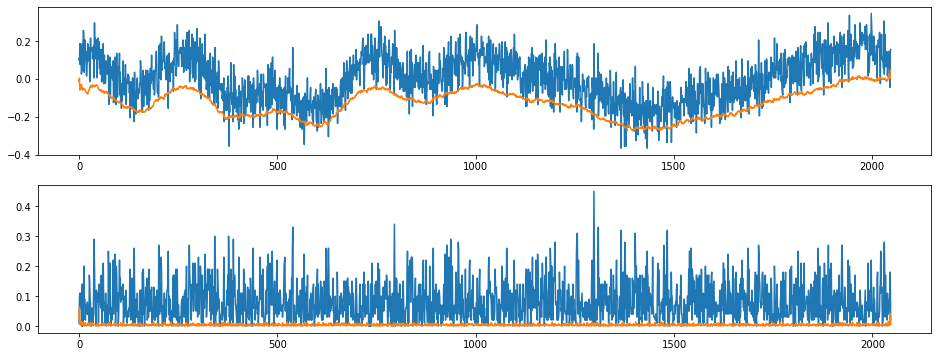

index:  242856
MAE:  0.13242492229172056
n_bunches        782
bunch_index     1173
bunch_number     519
Name: 7496323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6627/instability_data/06627_Inst_B1H_Q7_20180430_18h58m08s.h5


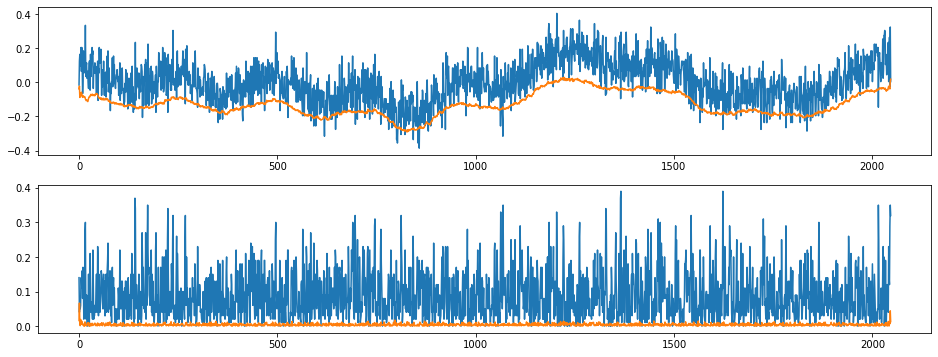

index:  397025
MAE:  0.13251978242176846
n_bunches       2556
bunch_index      446
bunch_number     295
Name: 11648045, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_15h31m14s.h5


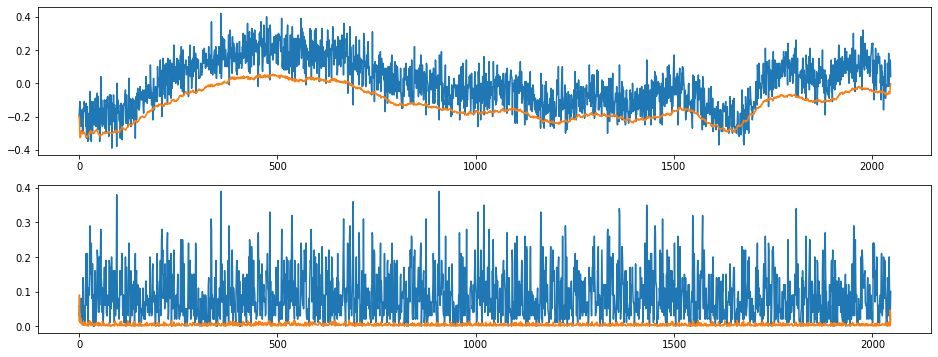

In [29]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [61]:
around_point_indices = np.argsort(np.abs(MAE_train - 6))

index:  22955
MAE:  6.022785635798355
n_bunches       636
bunch_index     714
bunch_number    523
Name: 11299620, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7109/instability_data/07109_Inst_B1H_Q7_20180831_19h43m00s.h5


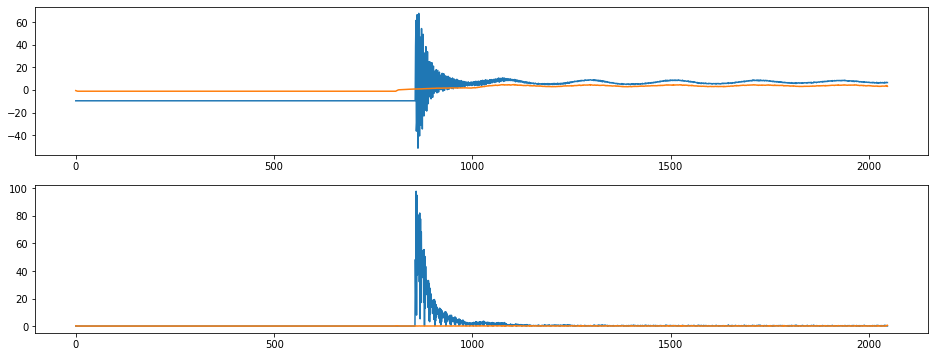

index:  73954
MAE:  6.082634686270212
n_bunches       492
bunch_index     493
bunch_number    114
Name: 3910113, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6429/instability_data/06429_Inst_B1H_Q7_20171128_03h23m14s.h5


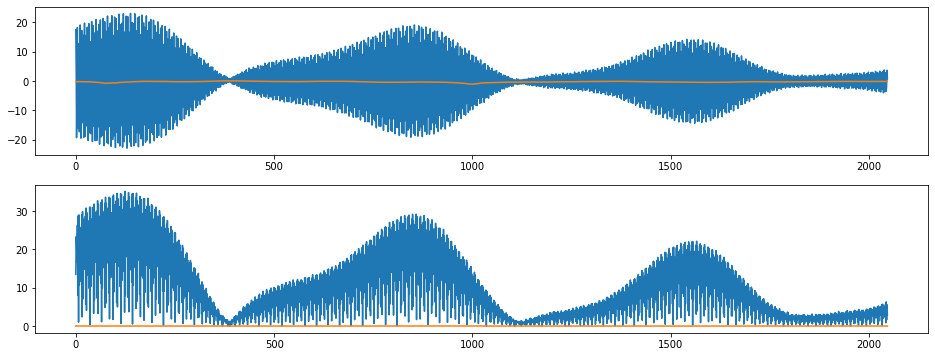

index:  189004
MAE:  5.915561592448794
n_bunches       1812
bunch_index      611
bunch_number     287
Name: 5156634, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_04h03m25s.h5


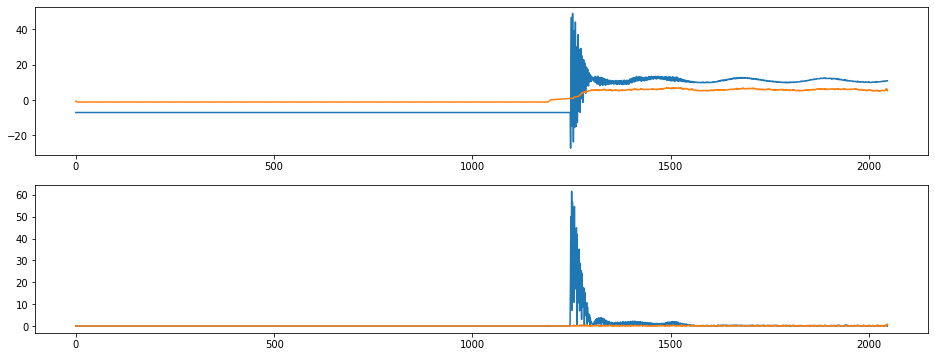

index:  268461
MAE:  5.890586459606386
n_bunches       396
bunch_index      86
bunch_number     18
Name: 452723, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6744/instability_data/06744_Inst_B1H_Q7_20180531_03h32m52s.h5


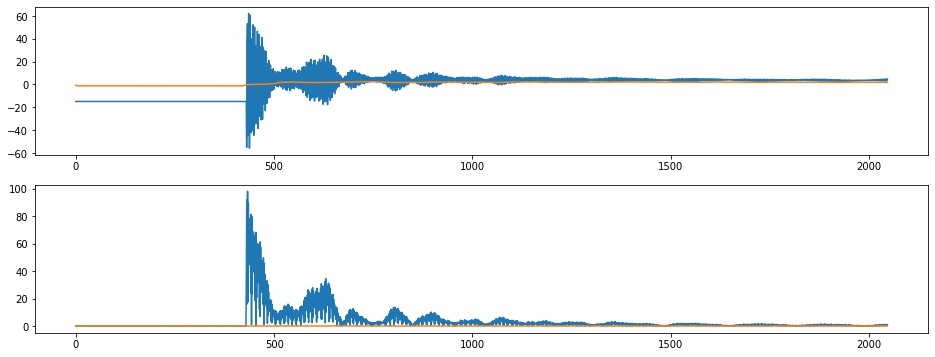

index:  241035
MAE:  5.88846104745975
n_bunches       376
bunch_index     988
bunch_number    205
Name: 4845389, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h36m37s.h5


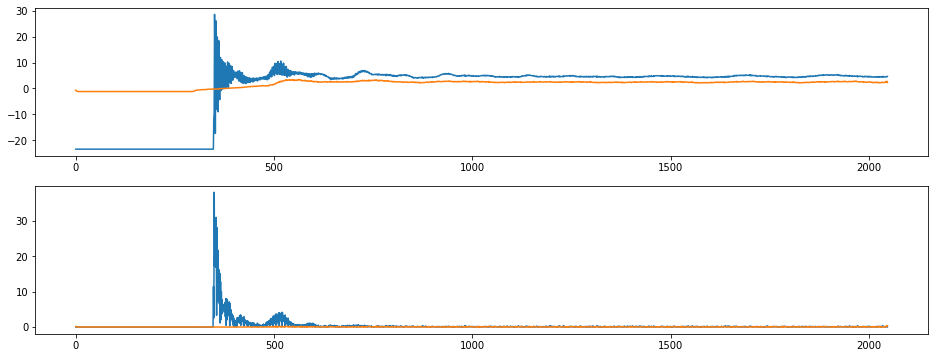

index:  162401
MAE:  5.886702524228602
n_bunches       1916
bunch_index     3378
bunch_number    1872
Name: 1653684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_21h33m14s.h5


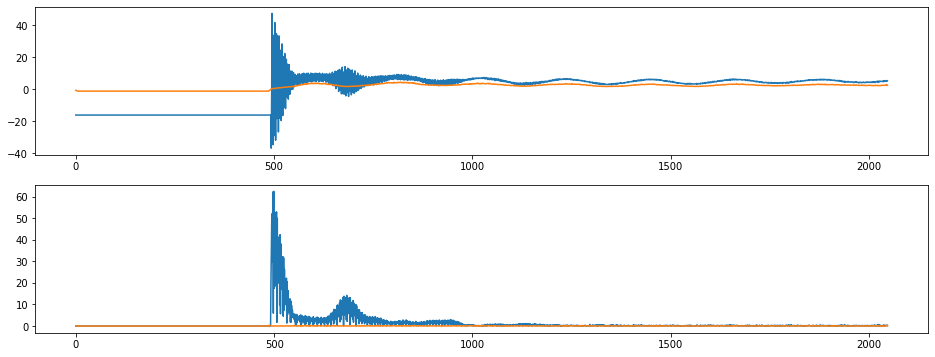

index:  78786
MAE:  5.885550656847481
n_bunches       410
bunch_index     336
bunch_number     73
Name: 9725228, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7306/instability_data/07306_Inst_B1H_Q7_20181015_06h35m08s.h5


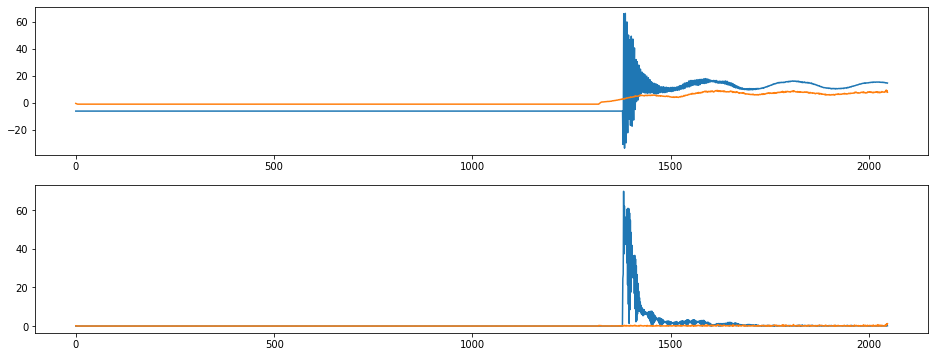

index:  97653
MAE:  6.1190320275168055
n_bunches        527
bunch_index     2345
bunch_number     478
Name: 817153, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_17h09m14s.h5


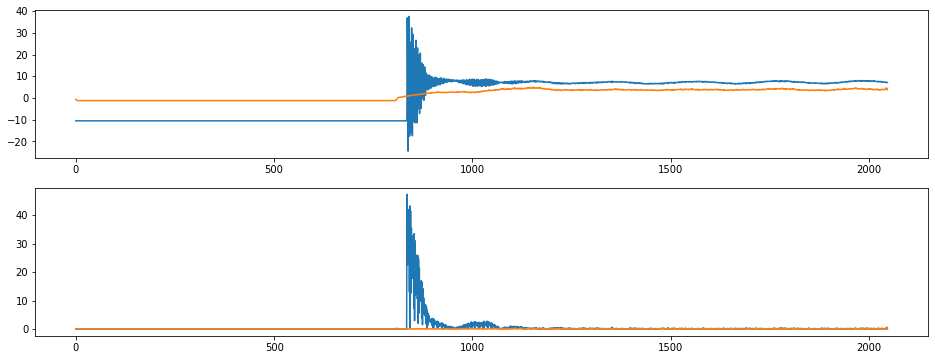

index:  74130
MAE:  6.135810681143629
n_bunches       1551
bunch_index      139
bunch_number      32
Name: 6473326, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_07h41m14s.h5


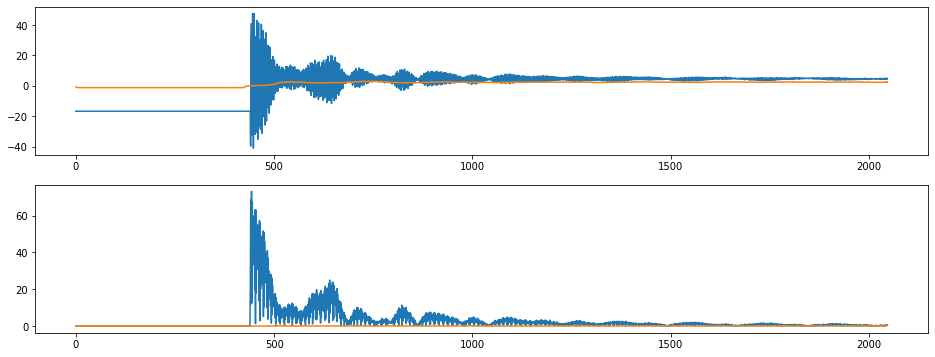

index:  277705
MAE:  6.153303506174489
n_bunches       1836
bunch_index     3396
bunch_number    1819
Name: 8627100, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_09h27m14s.h5


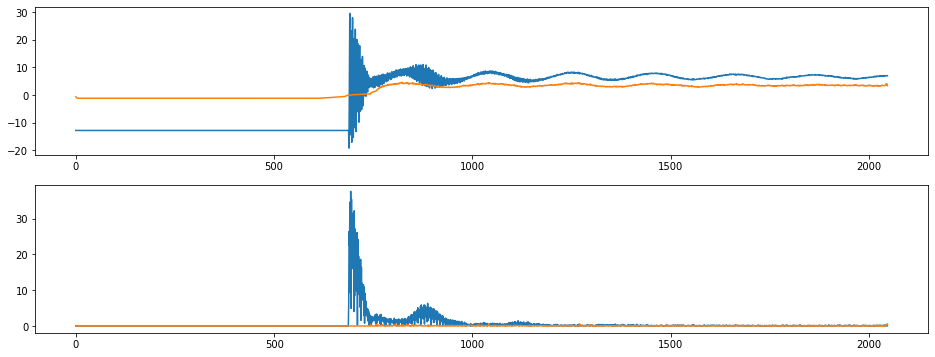

In [62]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [32]:
import keras

In [33]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [34]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 8, 8])

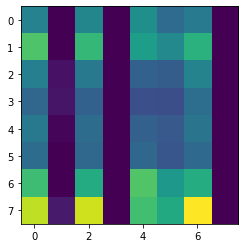

In [35]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  59832
MAE:  0.13114125258711284
n_bunches       396
bunch_index     251
bunch_number    145
Name: 8254716, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6677/instability_data/06677_Inst_B1H_Q7_20180513_12h54m58s.h5


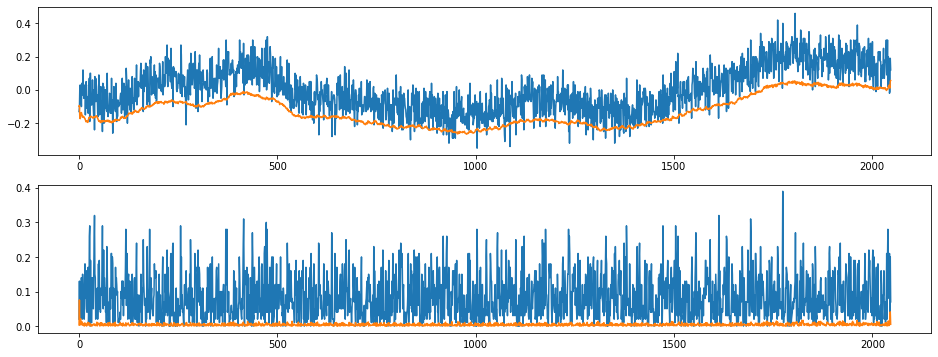

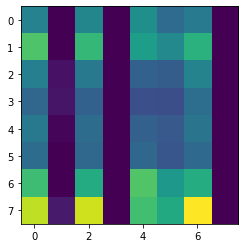

index:  394893
MAE:  0.13166002993275472
n_bunches       396
bunch_index     507
bunch_number    361
Name: 6777879, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7056/instability_data/07056_Inst_B1H_Q7_20180815_02h59m13s.h5


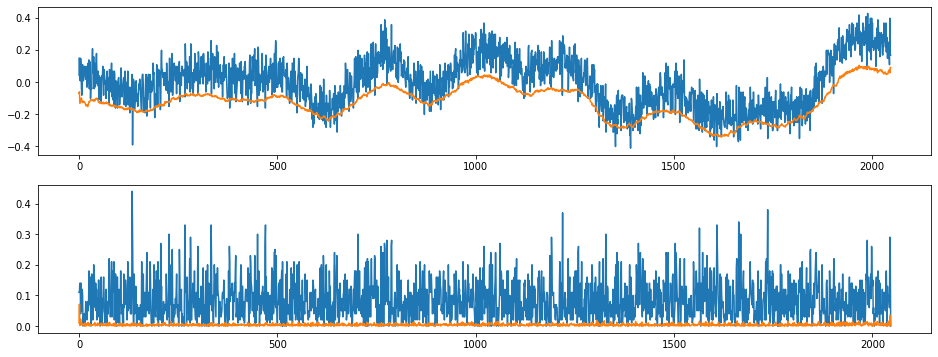

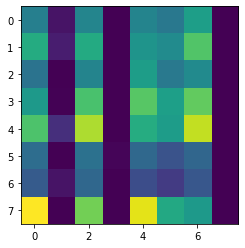

index:  4368
MAE:  0.13184286649298882
n_bunches       924
bunch_index     941
bunch_number    677
Name: 3159440, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h15m19s.h5


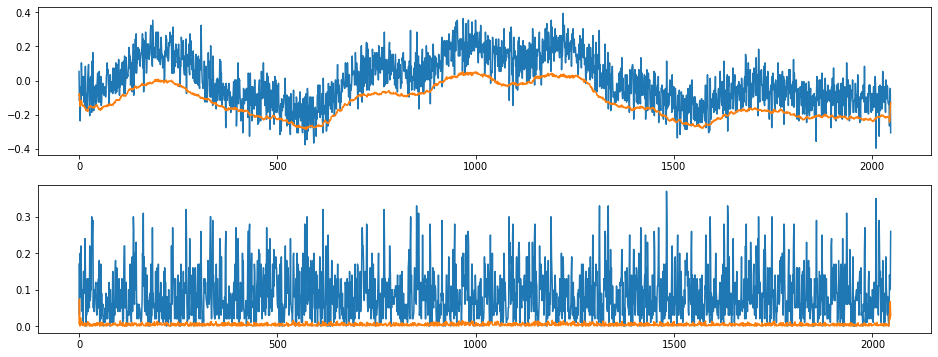

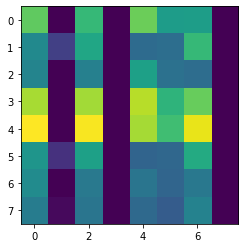

index:  85934
MAE:  0.1319180673707524
n_bunches       157
bunch_index     305
bunch_number     83
Name: 7141483, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6435/instability_data/06435_Inst_B1H_Q7_20171129_19h57m13s.h5


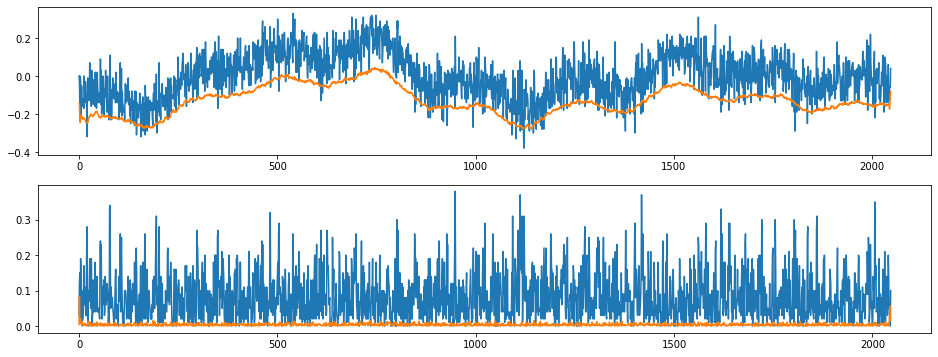

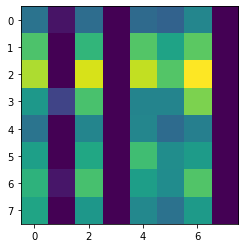

index:  147244
MAE:  0.1320874760057268
n_bunches       1868
bunch_index     3423
bunch_number    1852
Name: 10621317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_06h08m14s.h5


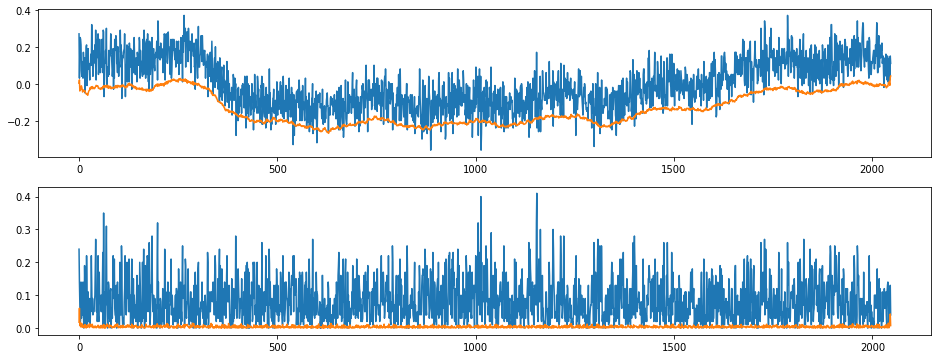

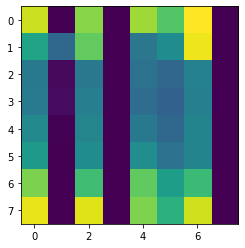

index:  367
MAE:  0.1321555714356873
n_bunches        684
bunch_index     1081
bunch_number     582
Name: 3496756, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6247/instability_data/06247_Inst_B1H_Q7_20170927_07h40m14s.h5


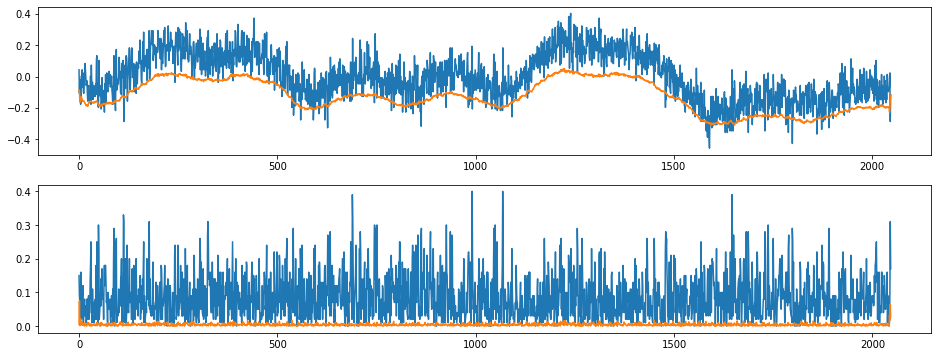

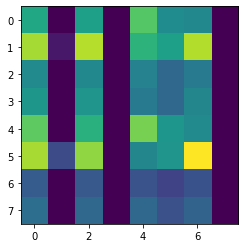

index:  147035
MAE:  0.13227418601622049
n_bunches       1868
bunch_index     3337
bunch_number    1800
Name: 8374461, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_09h56m14s.h5


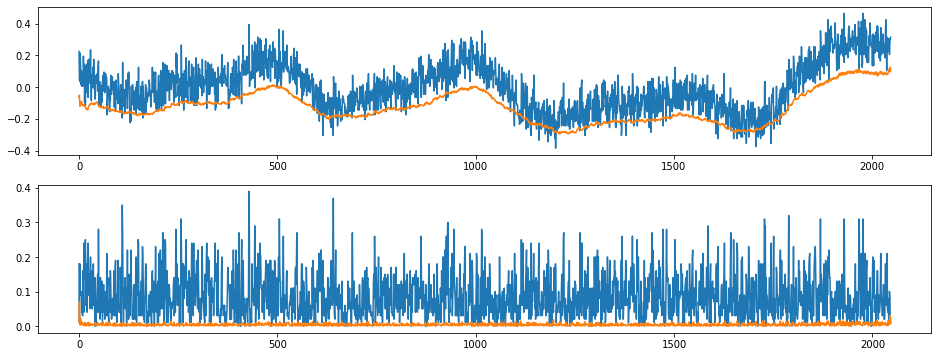

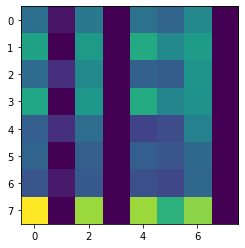

index:  379486
MAE:  0.132294425202781
n_bunches        780
bunch_index     1023
bunch_number     745
Name: 5789258, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_02h45m18s.h5


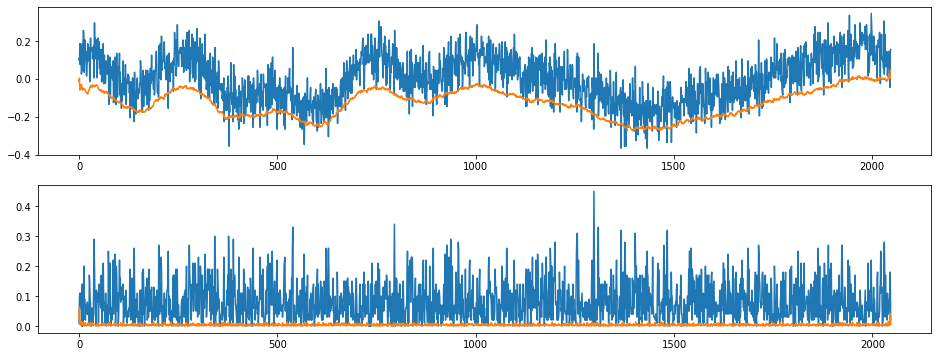

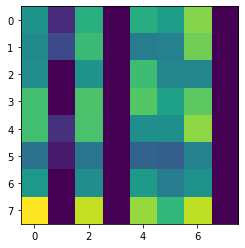

index:  242856
MAE:  0.13242492229172056
n_bunches        782
bunch_index     1173
bunch_number     519
Name: 7496323, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6627/instability_data/06627_Inst_B1H_Q7_20180430_18h58m08s.h5


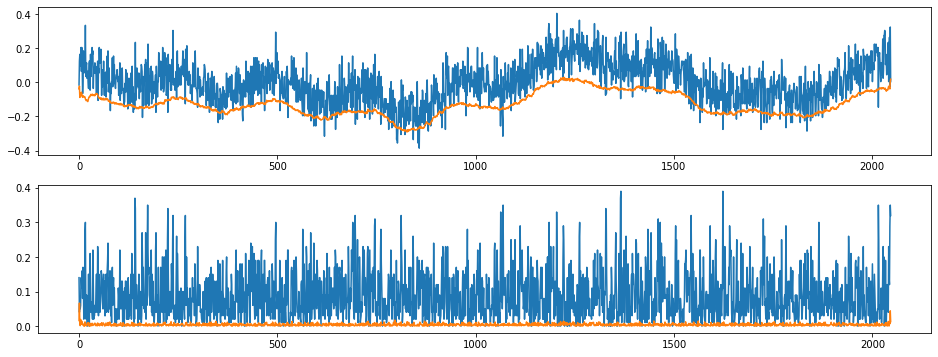

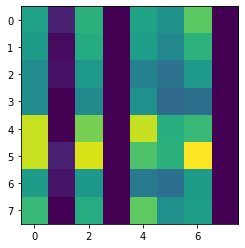

index:  397025
MAE:  0.13251978242176846
n_bunches       2556
bunch_index      446
bunch_number     295
Name: 11648045, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6757/instability_data/06757_Inst_B1H_Q7_20180604_15h31m14s.h5


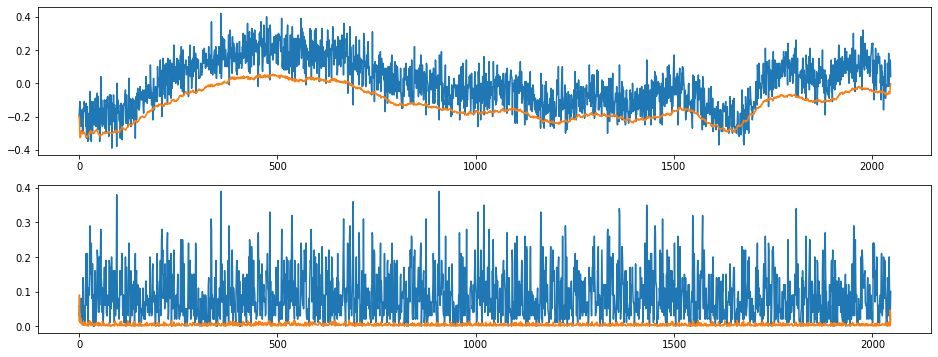

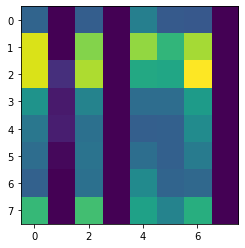

In [36]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  74178
MAE:  11.319369574327139
n_bunches       1227
bunch_index     1138
bunch_number     402
Name: 6018714, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_06h04m14s.h5


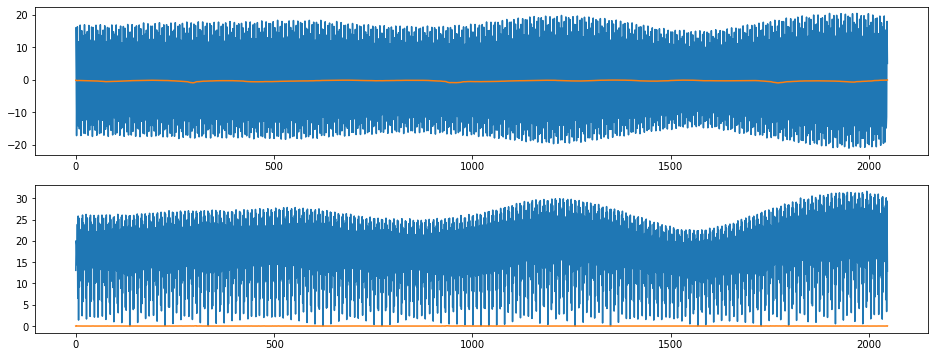

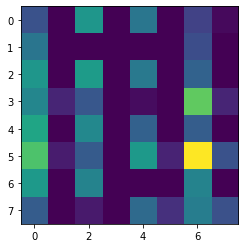

index:  78742
MAE:  10.919078901822068
n_bunches       1868
bunch_index      518
bunch_number     281
Name: 4111950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_12h03m14s.h5


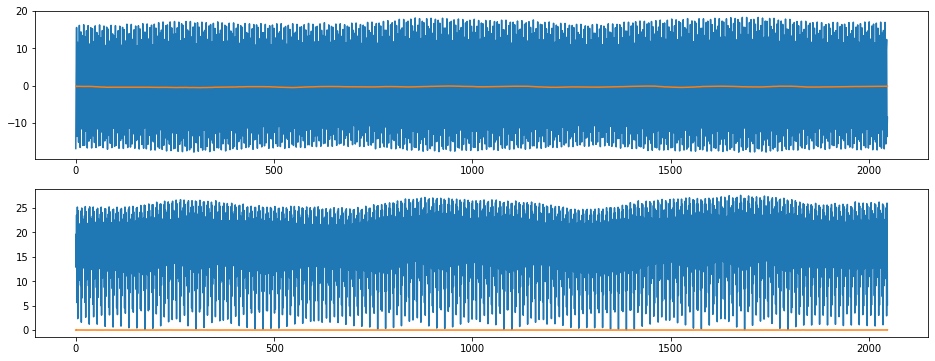

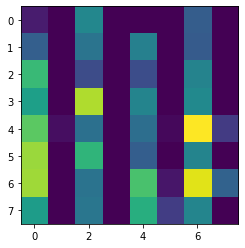

index:  224626
MAE:  10.342563704146487
n_bunches       1916
bunch_index      494
bunch_number     268
Name: 1169867, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_08h47m15s.h5


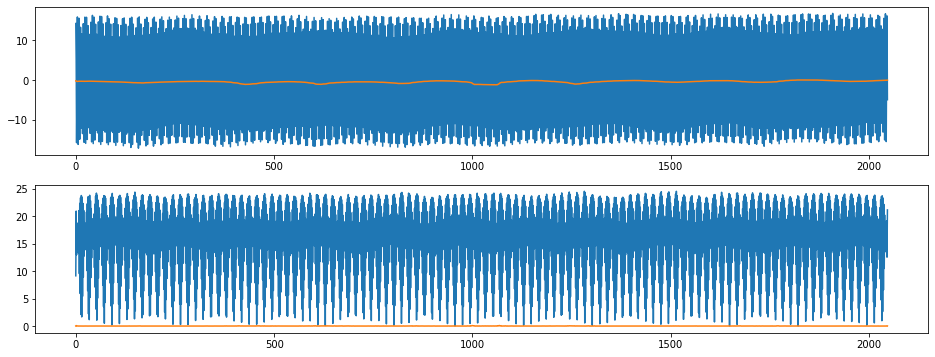

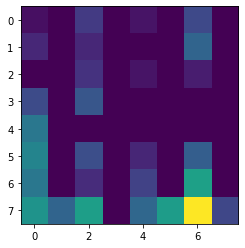

index:  74917
MAE:  10.328164314693204
n_bunches       1868
bunch_index      474
bunch_number     252
Name: 309793, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6355/instability_data/06355_Inst_B1H_Q7_20171101_19h27m14s.h5


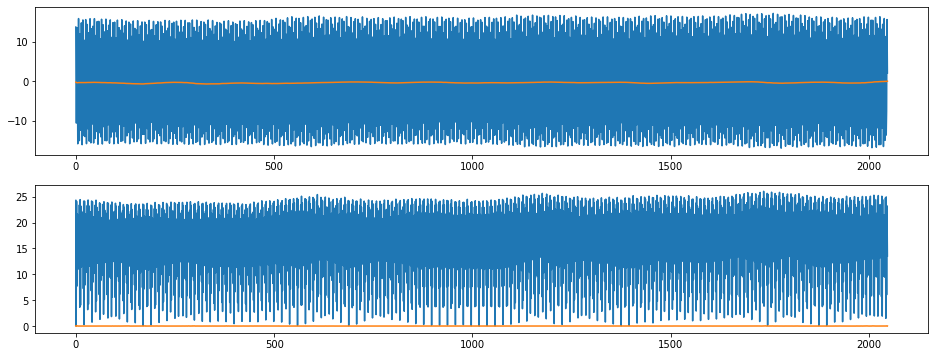

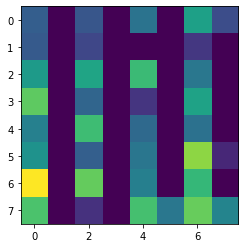

index:  77525
MAE:  10.239005779985455
n_bunches       336
bunch_index     151
bunch_number     24
Name: 2863291, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7443/instability_data/07443_Inst_B1H_Q7_20181114_03h46m14s.h5


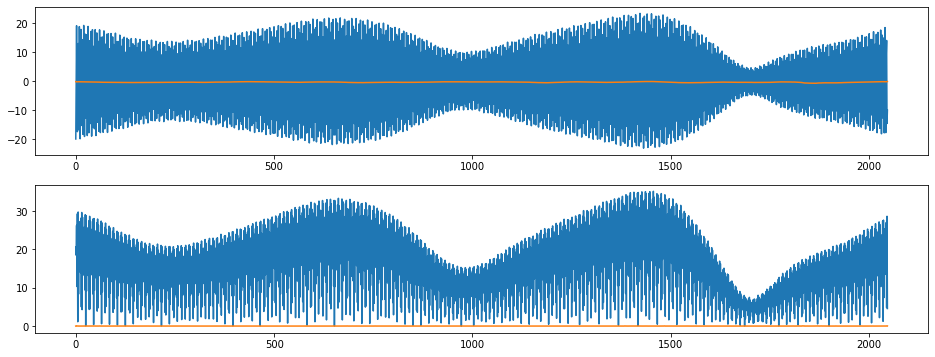

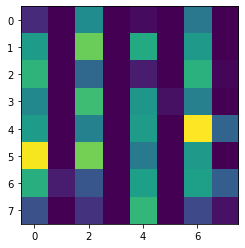

index:  221778
MAE:  10.23599762395661
n_bunches       1868
bunch_index        1
bunch_number       1
Name: 3803100, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6370/instability_data/06370_Inst_B1H_Q7_20171109_04h30m14s.h5


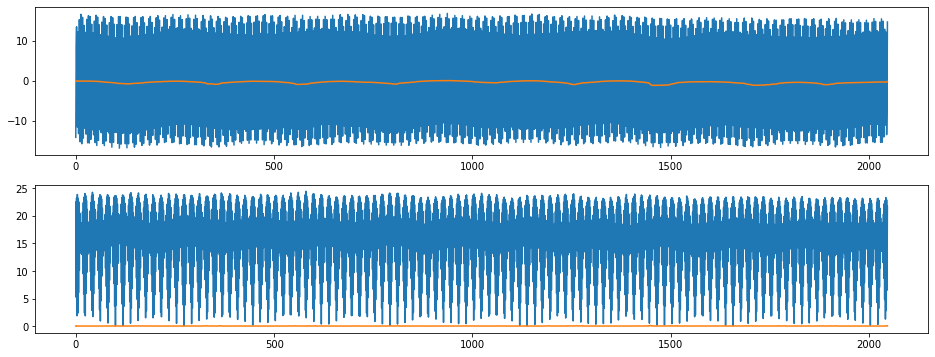

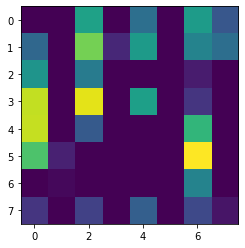

index:  221326
MAE:  9.823305588116746
n_bunches       652
bunch_index     402
bunch_number    207
Name: 1695976, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6355/instability_data/06355_Inst_B1H_Q7_20171101_18h21m18s.h5


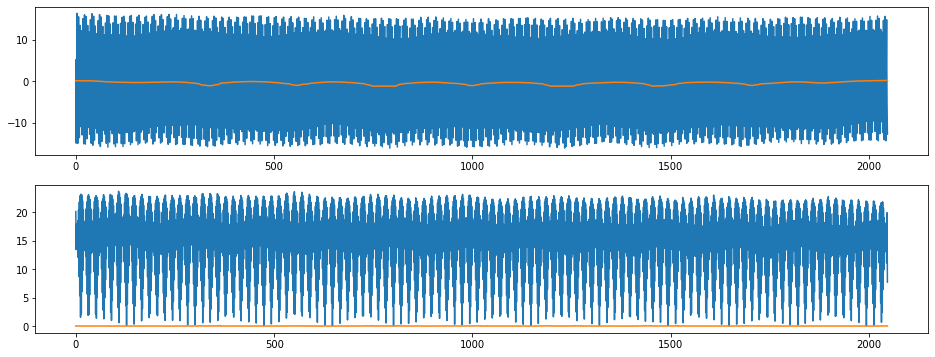

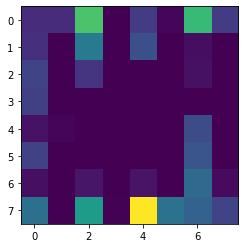

index:  78036
MAE:  9.547472524700861
n_bunches        376
bunch_index     1630
bunch_number     346
Name: 8739639, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_17h55m16s.h5


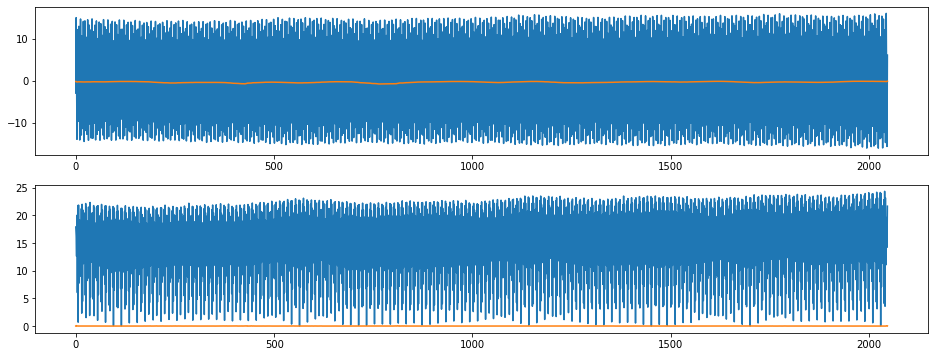

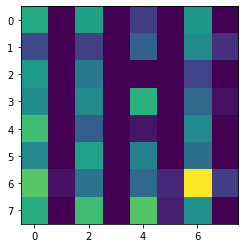

index:  1304
MAE:  9.420575242010237
n_bunches       2556
bunch_index      127
bunch_number      71
Name: 4666402, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180807_00h17m15s.h5


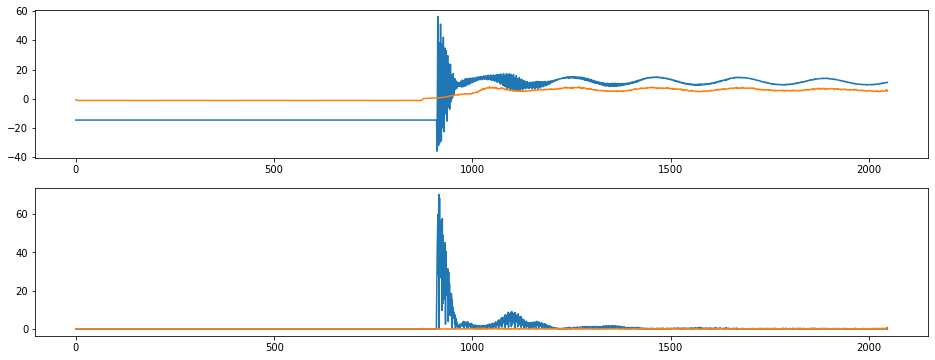

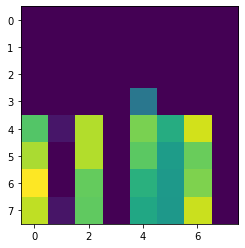

index:  268696
MAE:  9.25528207731848
n_bunches       2175
bunch_index     2840
bunch_number    1827
Name: 7711481, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_11h56m13s.h5


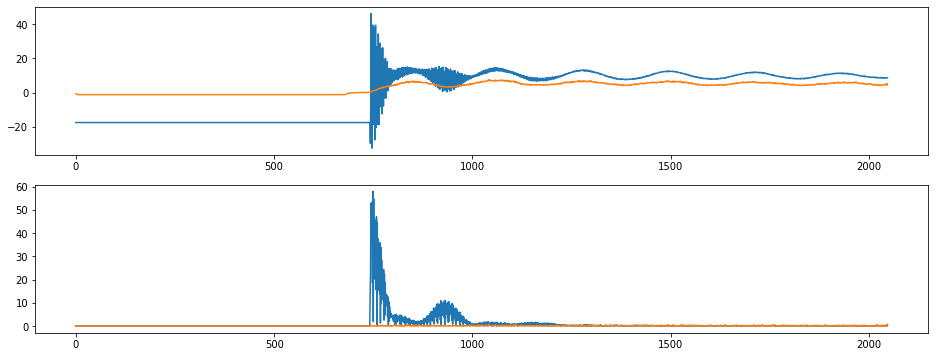

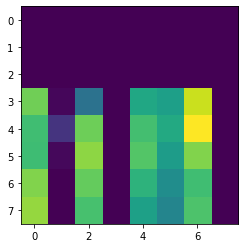

index:  250246
MAE:  9.209695227577324
n_bunches        408
bunch_index     2115
bunch_number     291
Name: 10799702, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_02h30m11s.h5


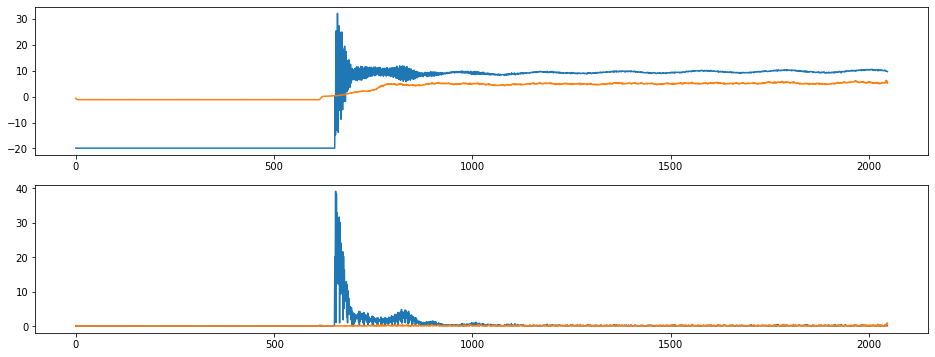

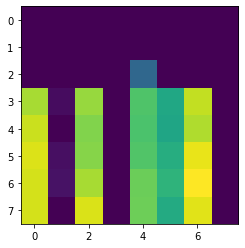

index:  260669
MAE:  9.157632976414895
n_bunches       516
bunch_index     103
bunch_number     68
Name: 1870058, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6602/instability_data/06602_Inst_B1H_Q7_20180423_17h04m45s.h5


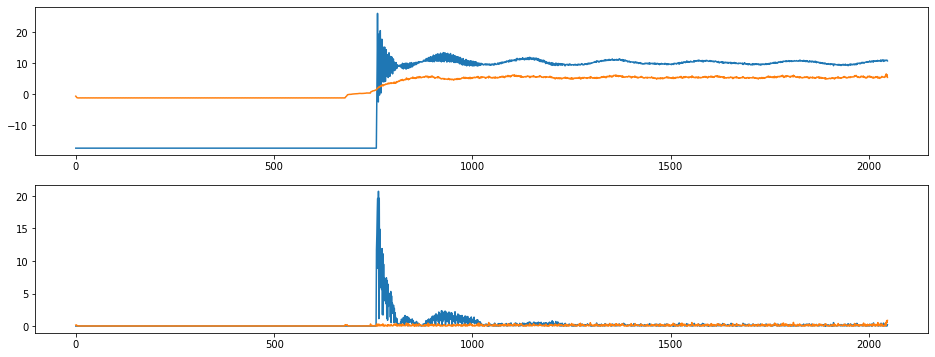

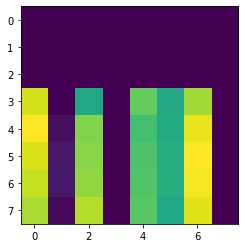

index:  191231
MAE:  9.023542727537535
n_bunches       540
bunch_index     275
bunch_number    181
Name: 10873407, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7109/instability_data/07109_Inst_B1H_Q7_20180831_19h42m15s.h5


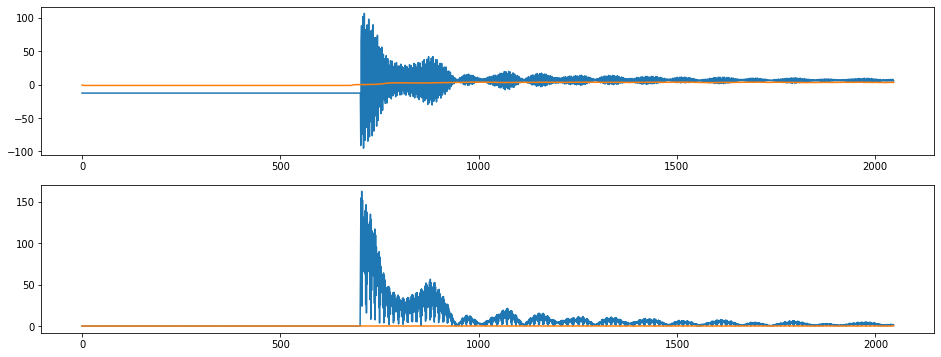

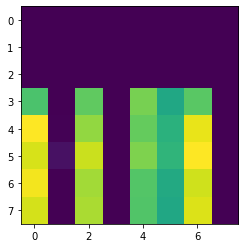

index:  47866
MAE:  8.859220722747267
n_bunches       1227
bunch_index     2055
bunch_number     755
Name: 170224, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_10h26m14s.h5


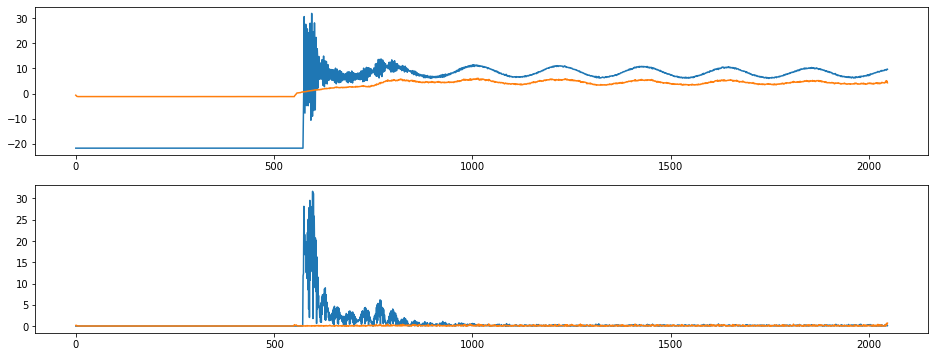

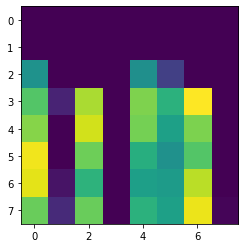

index:  77493
MAE:  8.528288853614468
n_bunches       396
bunch_index     141
bunch_number     66
Name: 4520393, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6710/instability_data/06710_Inst_B1H_Q7_20180521_12h28m16s.h5


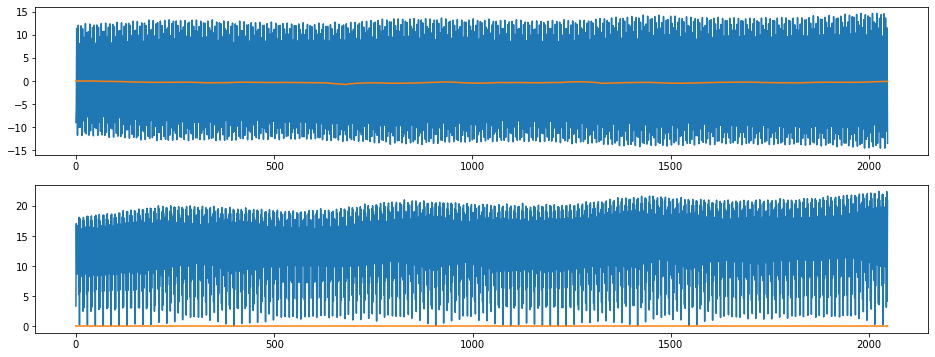

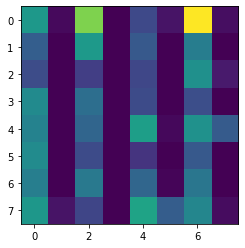

index:  159968
MAE:  8.319341114334673
n_bunches       1916
bunch_index     2507
bunch_number    1391
Name: 11488692, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170929_03h09m15s.h5


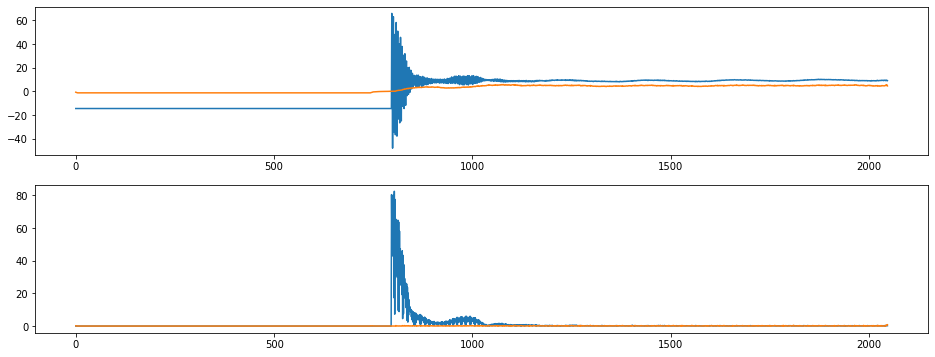

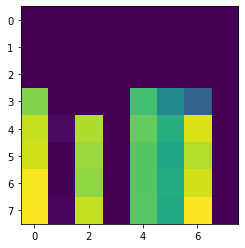

index:  375649
MAE:  8.299247157478531
n_bunches       2556
bunch_index     1565
bunch_number    1159
Name: 11517356, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7037/instability_data/07037_Inst_B1H_Q7_20180808_03h53m14s.h5


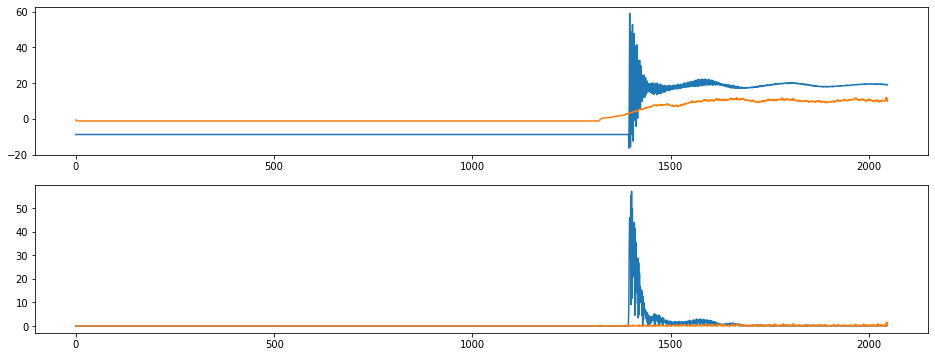

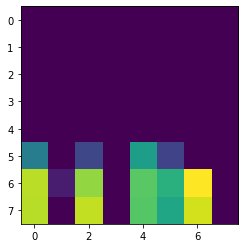

index:  307812
MAE:  7.871892648668725
n_bunches       252
bunch_index     334
bunch_number    233
Name: 7030955, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7109/instability_data/07109_Inst_B1H_Q7_20180831_19h39m49s.h5


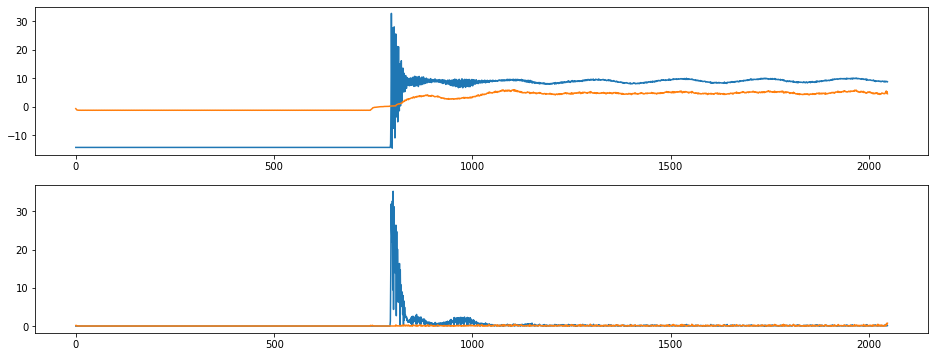

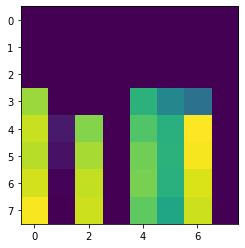

index:  156721
MAE:  7.823264204856166
n_bunches        656
bunch_index     1386
bunch_number     275
Name: 1520076, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_17h11m15s.h5


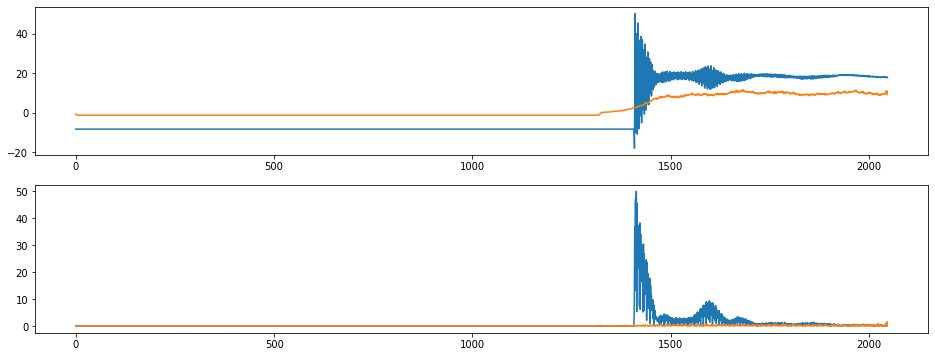

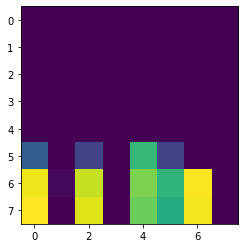

index:  386464
MAE:  7.775141902599717
n_bunches       1868
bunch_index      513
bunch_number     276
Name: 8830948, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_14h23m31s.h5


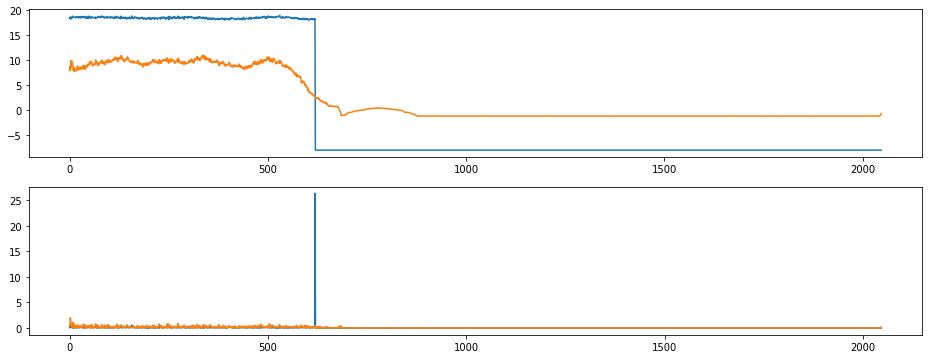

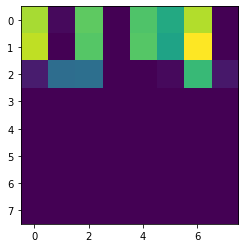

index:  175157
MAE:  7.674194669815842
n_bunches       1916
bunch_index     2612
bunch_number    1442
Name: 2348549, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_21h31m14s.h5


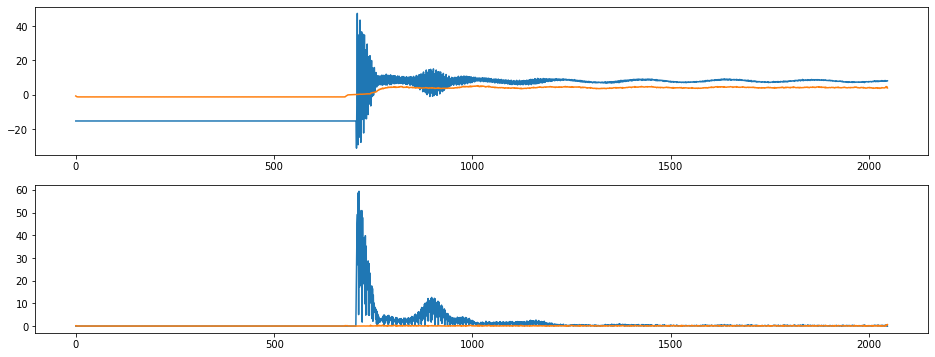

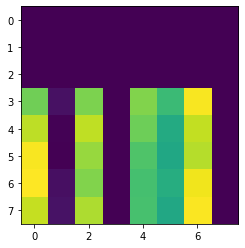

index:  225301
MAE:  7.5126451482140695
n_bunches        376
bunch_index     1352
bunch_number     283
Name: 8417765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7481/instability_data/07481_Inst_B1H_Q7_20181128_09h46m47s.h5


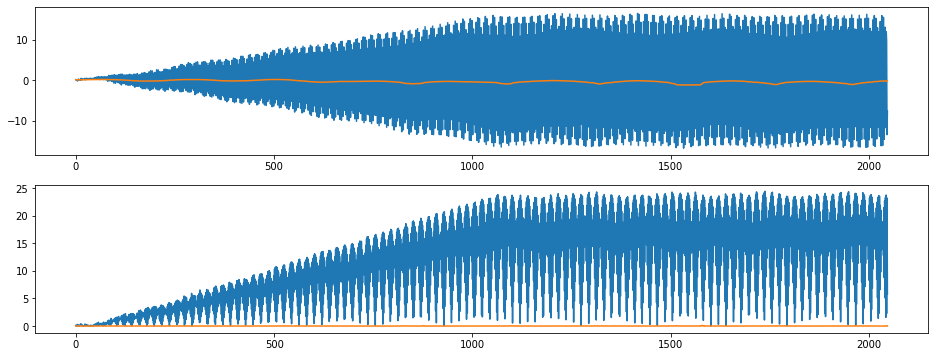

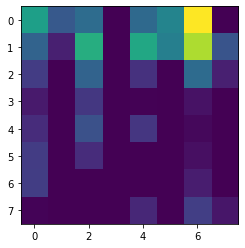

index:  85204
MAE:  7.5100502076325935
n_bunches       524
bunch_index     161
bunch_number     73
Name: 8452328, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_02h17m14s.h5


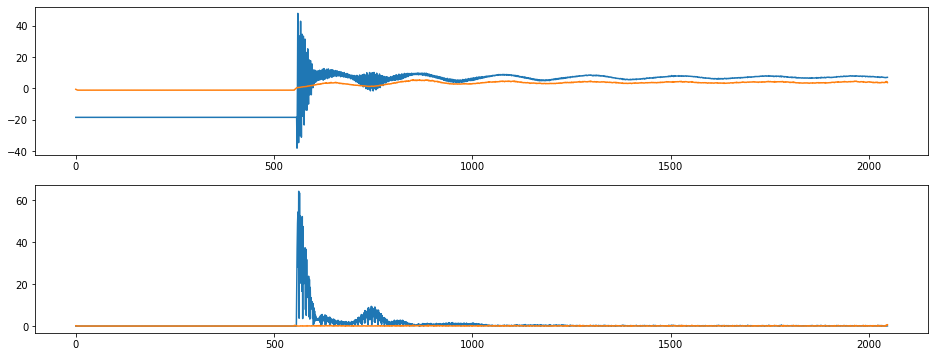

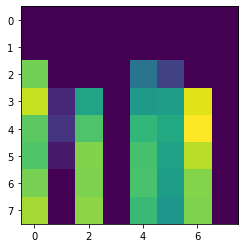

index:  377357
MAE:  7.45999132637018
n_bunches       1227
bunch_index       68
bunch_number      19
Name: 7617953, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_07h27m14s.h5


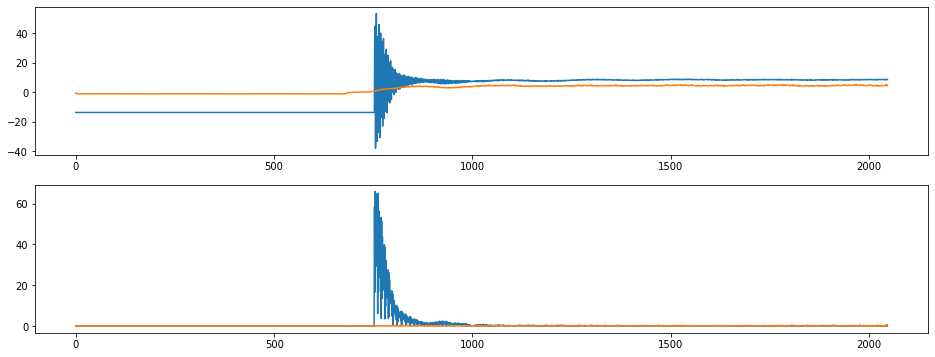

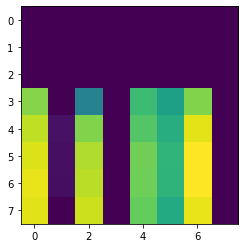

index:  80499
MAE:  7.419885958894337
n_bunches       540
bunch_index     608
bunch_number    431
Name: 4116482, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7101/instability_data/07101_Inst_B1H_Q7_20180829_22h21m14s.h5


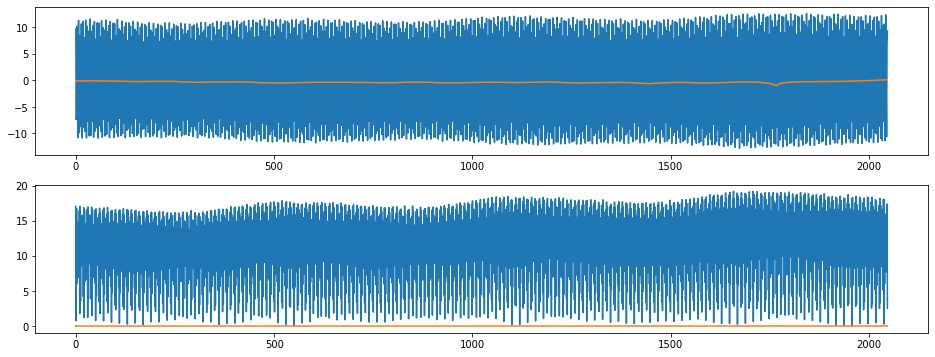

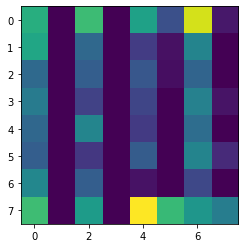

index:  270308
MAE:  7.191250294525089
n_bunches       300
bunch_index     407
bunch_number    293
Name: 6175174, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6898/instability_data/06898_Inst_B1H_Q7_20180708_00h49m16s.h5


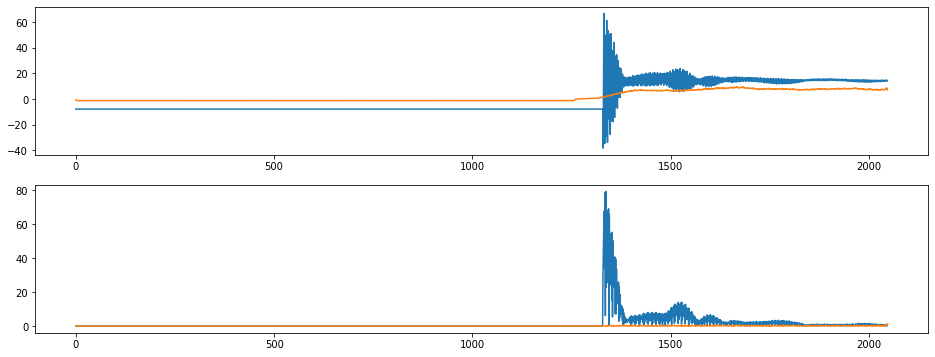

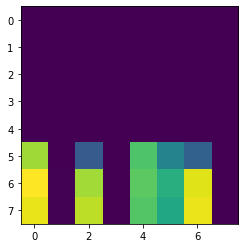

index:  134997
MAE:  7.109018506561696
n_bunches       1452
bunch_index     1996
bunch_number     843
Name: 9810405, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_13h42m20s.h5


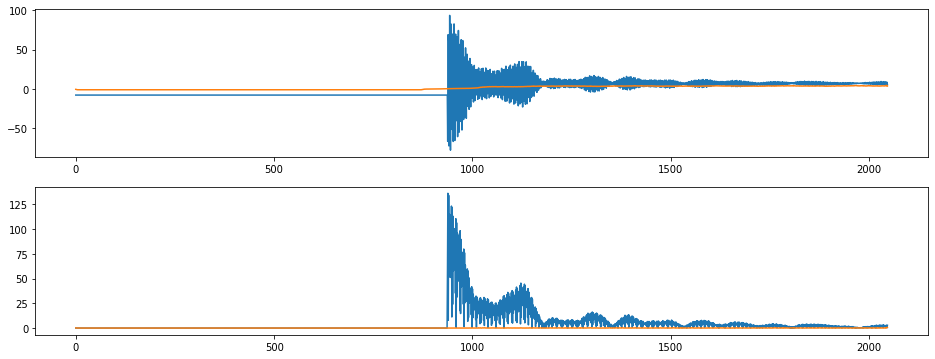

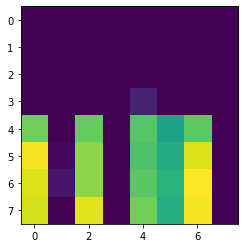

index:  314142
MAE:  7.082258871208468
n_bunches       1212
bunch_index      457
bunch_number     318
Name: 7940103, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_10h46m08s.h5


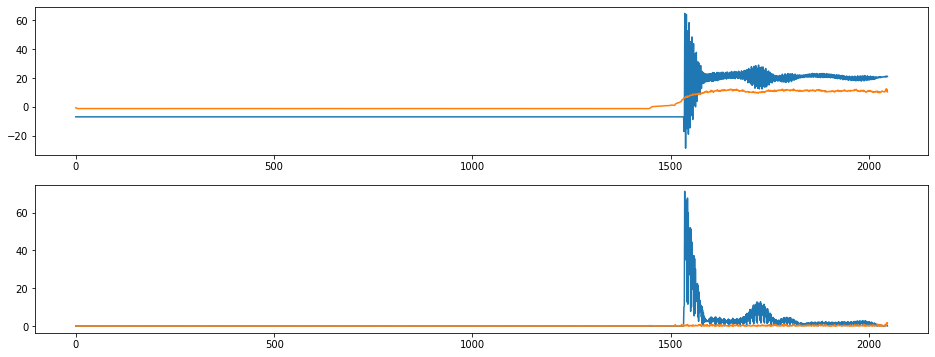

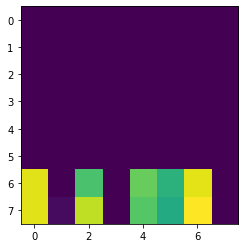

index:  362582
MAE:  7.0000228788370435
n_bunches       132
bunch_index     621
bunch_number     67
Name: 1348050, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_08h38m14s.h5


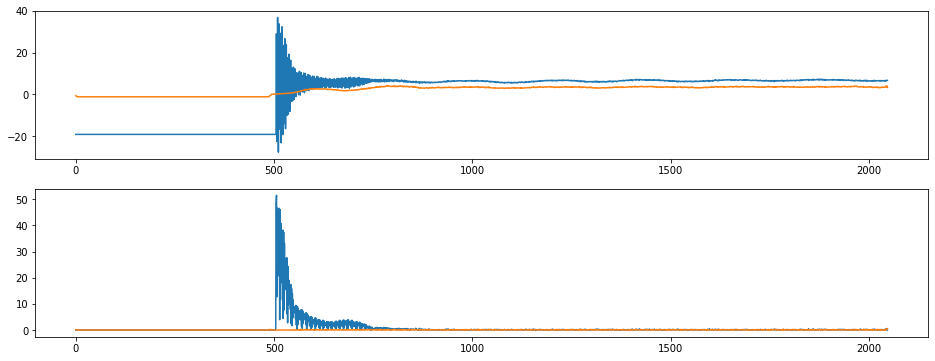

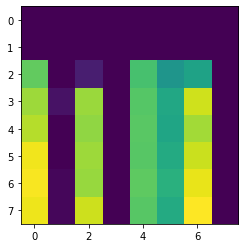

index:  213759
MAE:  6.888445005471004
n_bunches       1068
bunch_index      333
bunch_number     232
Name: 2903182, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7128/instability_data/07128_Inst_B1H_Q7_20180906_03h16m33s.h5


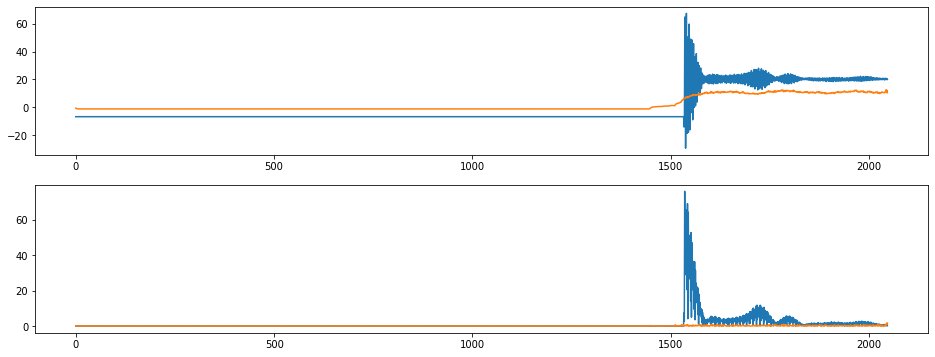

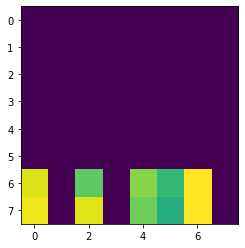

index:  248680
MAE:  6.879561959874299
n_bunches       1452
bunch_index     2478
bunch_number    1045
Name: 3534118, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180706_01h31m14s.h5


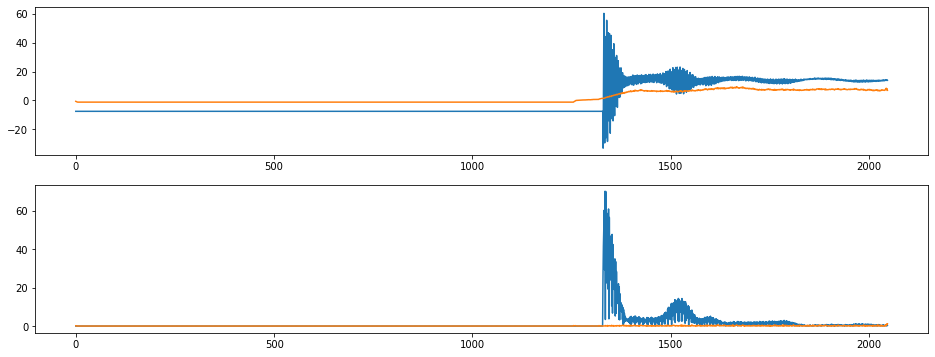

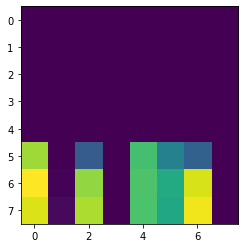

index:  301796
MAE:  6.781722545403901
n_bunches       158
bunch_index     399
bunch_number    143
Name: 5924013, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7169/instability_data/07169_Inst_B1H_Q7_20180914_08h40m19s.h5


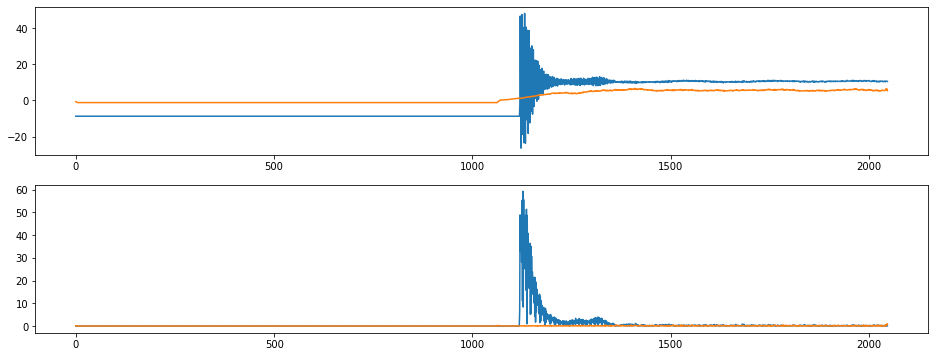

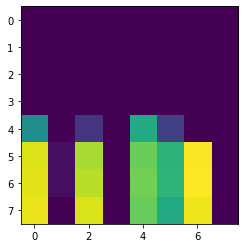

index:  202924
MAE:  6.7631080996300454
n_bunches       2556
bunch_index      966
bunch_number     695
Name: 7647137, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6966/instability_data/06966_Inst_B1H_Q7_20180724_00h53m27s.h5


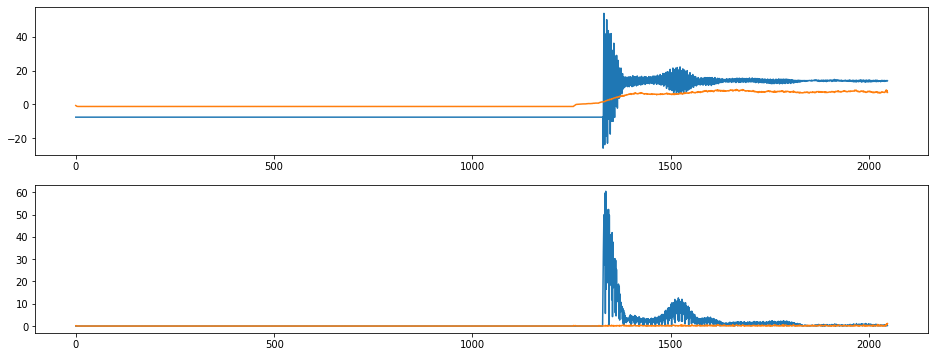

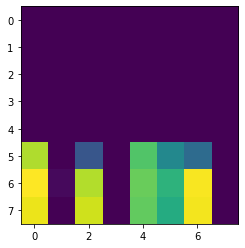

index:  391198
MAE:  6.622427752888289
n_bunches       170
bunch_index     157
bunch_number     36
Name: 10985942, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6595/instability_data/06595_Inst_B1H_Q7_20180422_21h04m14s.h5


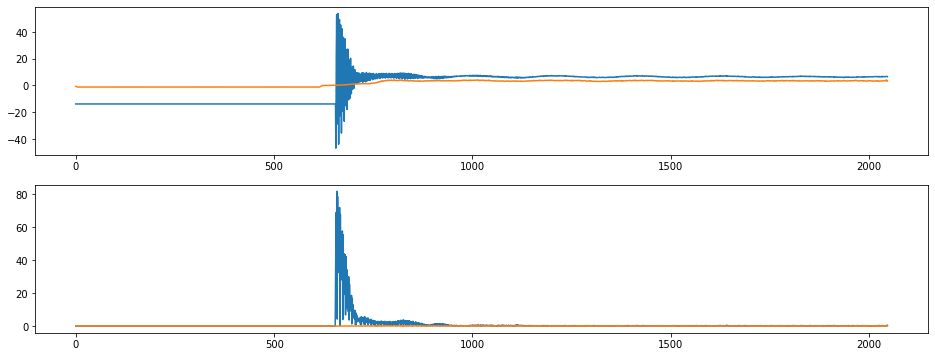

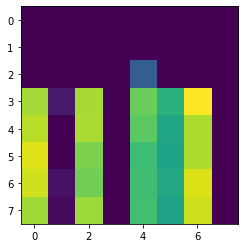

index:  43010
MAE:  6.500509384806898
n_bunches       1868
bunch_index     3258
bunch_number    1748
Name: 616415, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6278/instability_data/06278_Inst_B1H_Q7_20171007_03h51m14s.h5


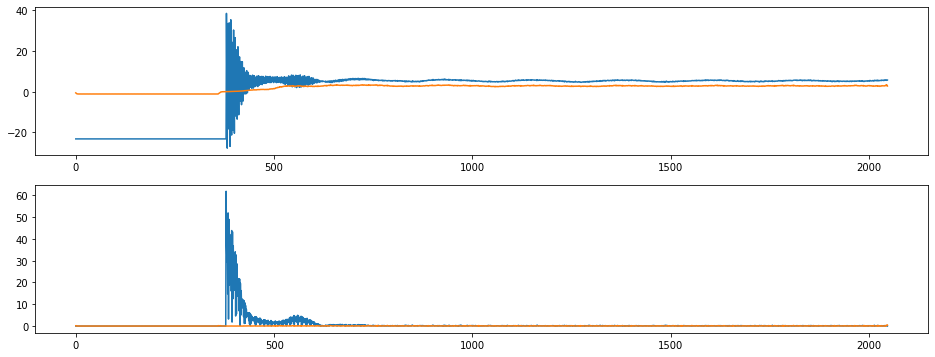

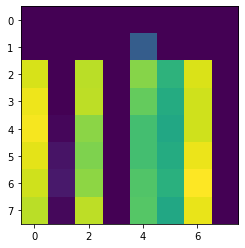

index:  368073
MAE:  6.479701455795439
n_bunches       2460
bunch_index     1112
bunch_number     821
Name: 2182559, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6640/instability_data/06640_Inst_B1H_Q7_20180504_09h58m15s.h5


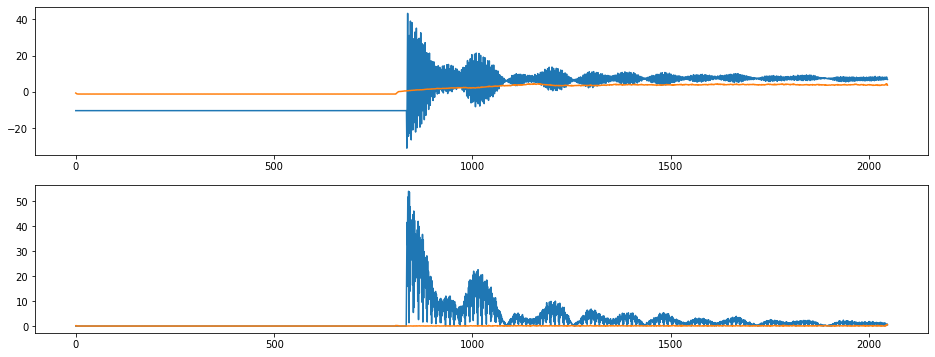

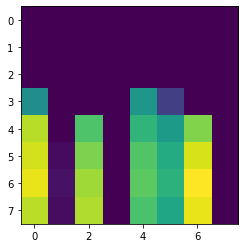

index:  79558
MAE:  6.468576501421739
n_bunches       924
bunch_index     924
bunch_number    641
Name: 4877594, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6741/instability_data/06741_Inst_B1H_Q7_20180530_10h07m00s.h5


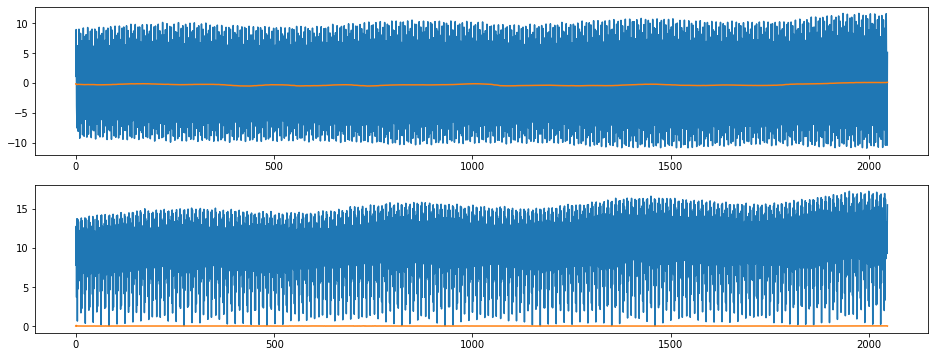

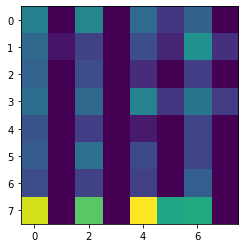

index:  125946
MAE:  6.360279447751818
n_bunches       2175
bunch_index     3037
bunch_number    1979
Name: 4984755, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_10h01m14s.h5


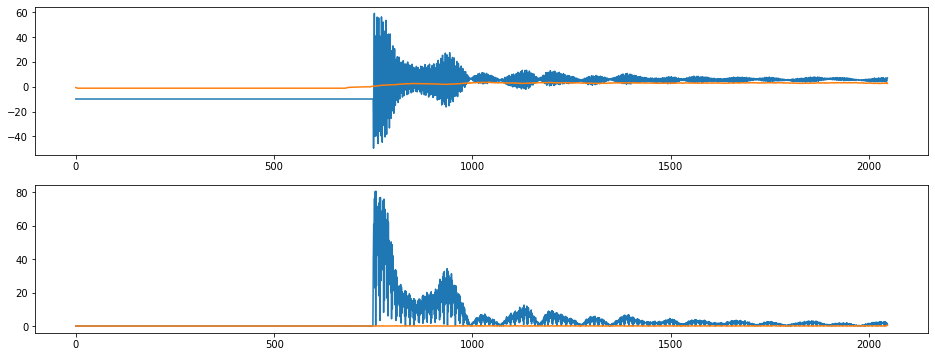

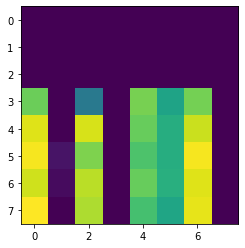

index:  224889
MAE:  6.322163107026899
n_bunches       468
bunch_index     726
bunch_number    234
Name: 6314032, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/instability_data/06576_Inst_B1H_Q7_20180419_19h40m13s.h5


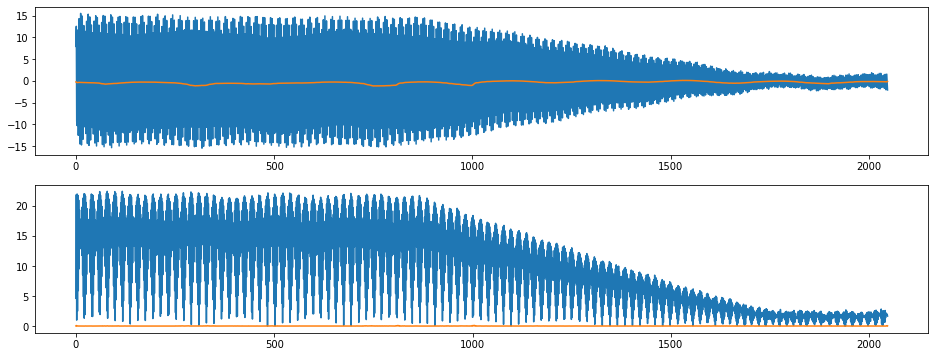

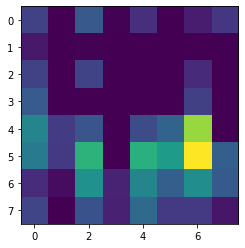

index:  60378
MAE:  6.169798787476029
n_bunches        794
bunch_index     1379
bunch_number     500
Name: 9295581, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6854/instability_data/06854_Inst_B1H_Q7_20180627_21h44m00s.h5


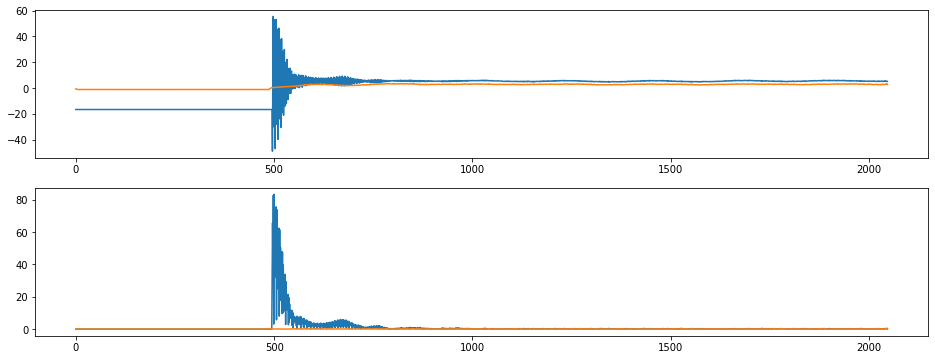

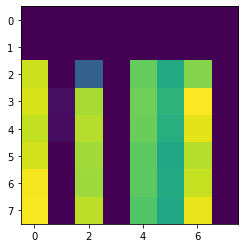

index:  277705
MAE:  6.153303506174489
n_bunches       1836
bunch_index     3396
bunch_number    1819
Name: 8627100, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_09h27m14s.h5


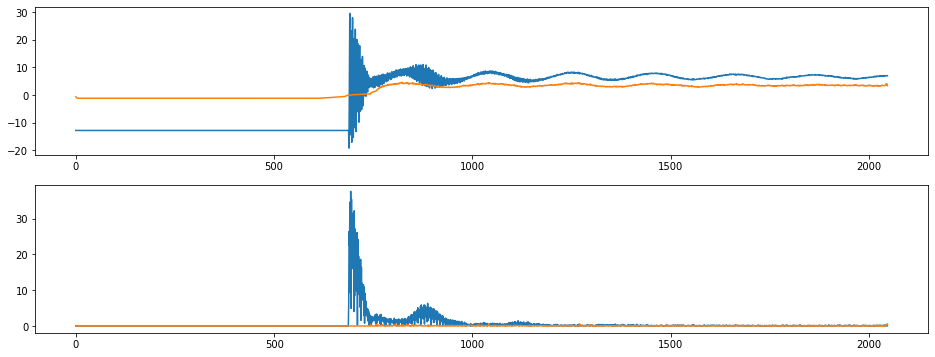

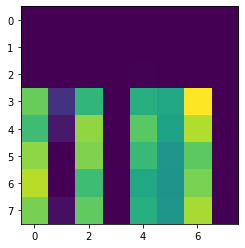

index:  74130
MAE:  6.135810681143629
n_bunches       1551
bunch_index      139
bunch_number      32
Name: 6473326, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6628/instability_data/06628_Inst_B1H_Q7_20180501_07h41m14s.h5


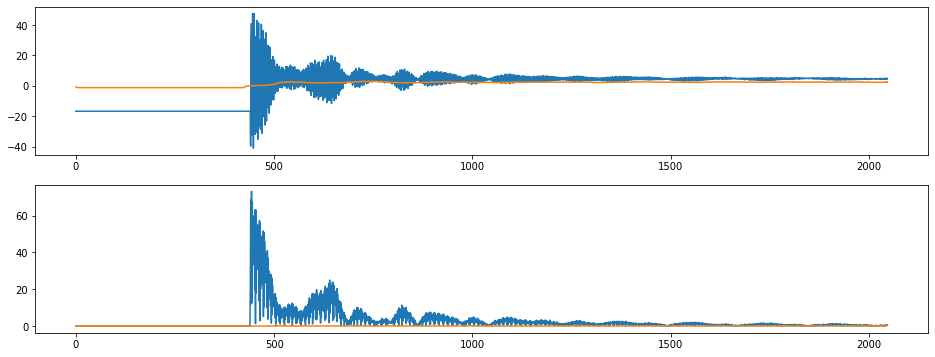

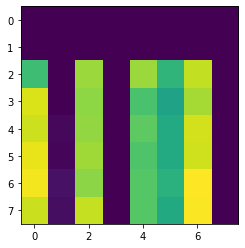

index:  97653
MAE:  6.1190320275168055
n_bunches        527
bunch_index     2345
bunch_number     478
Name: 817153, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6404/instability_data/06404_Inst_B1H_Q7_20171121_17h09m14s.h5


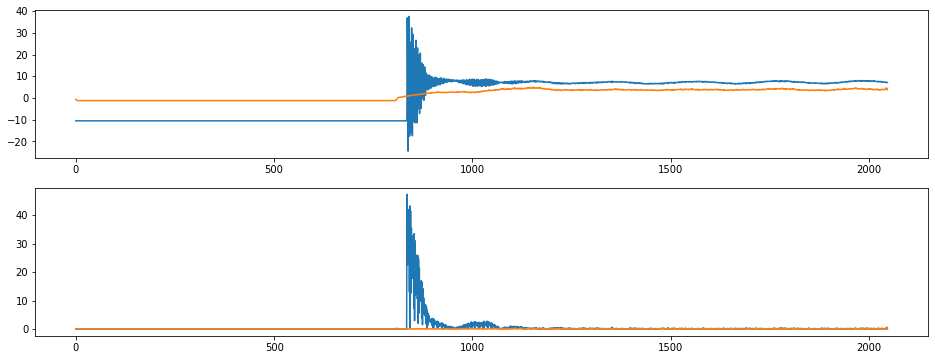

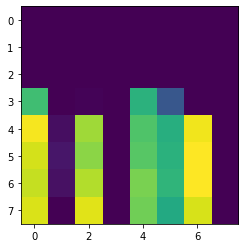

index:  73954
MAE:  6.082634686270212
n_bunches       492
bunch_index     493
bunch_number    114
Name: 3910113, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6429/instability_data/06429_Inst_B1H_Q7_20171128_03h23m14s.h5


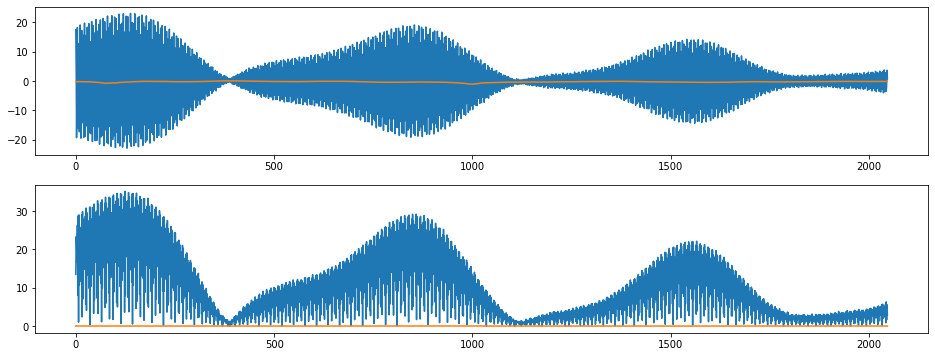

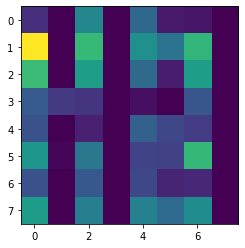

index:  22955
MAE:  6.022785635798355
n_bunches       636
bunch_index     714
bunch_number    523
Name: 11299620, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7109/instability_data/07109_Inst_B1H_Q7_20180831_19h43m00s.h5


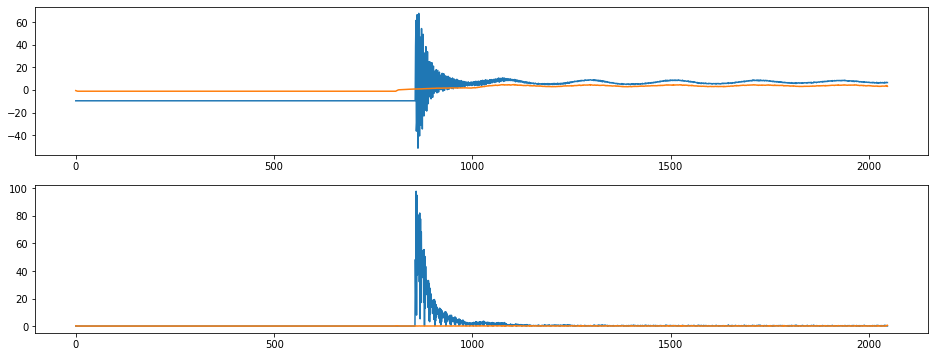

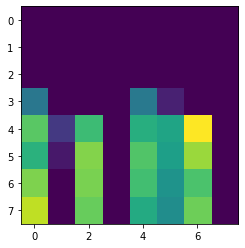

index:  189004
MAE:  5.915561592448794
n_bunches       1812
bunch_index      611
bunch_number     287
Name: 5156634, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_04h03m25s.h5


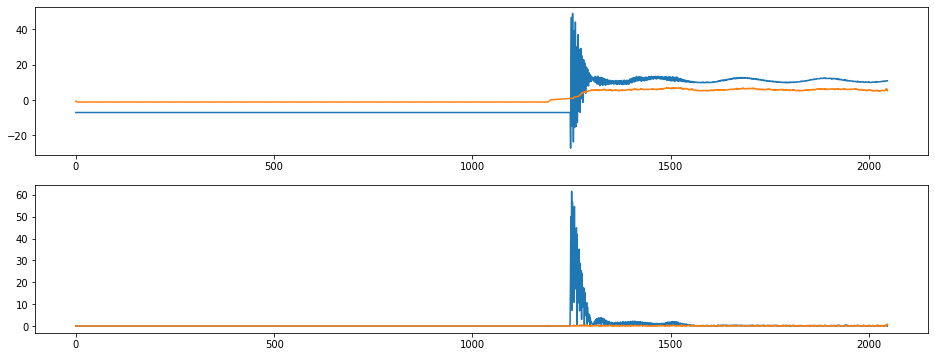

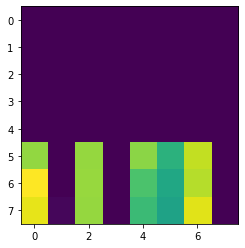

index:  268461
MAE:  5.890586459606386
n_bunches       396
bunch_index      86
bunch_number     18
Name: 452723, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6744/instability_data/06744_Inst_B1H_Q7_20180531_03h32m52s.h5


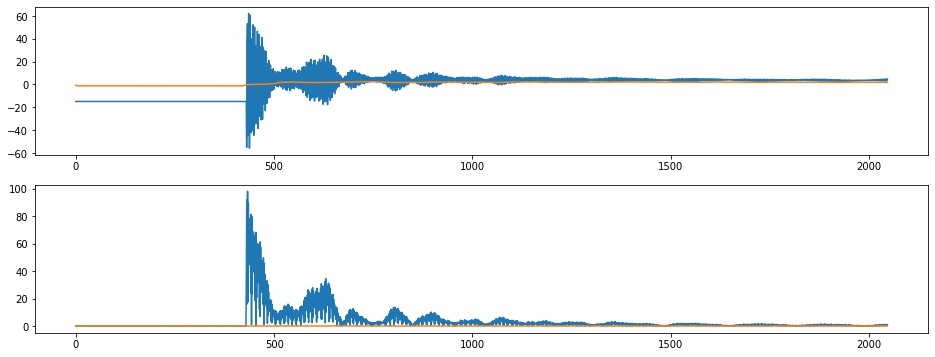

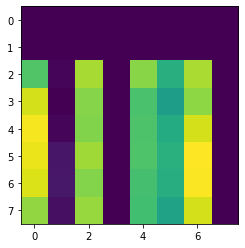

index:  241035
MAE:  5.88846104745975
n_bunches       376
bunch_index     988
bunch_number    205
Name: 4845389, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_19h36m37s.h5


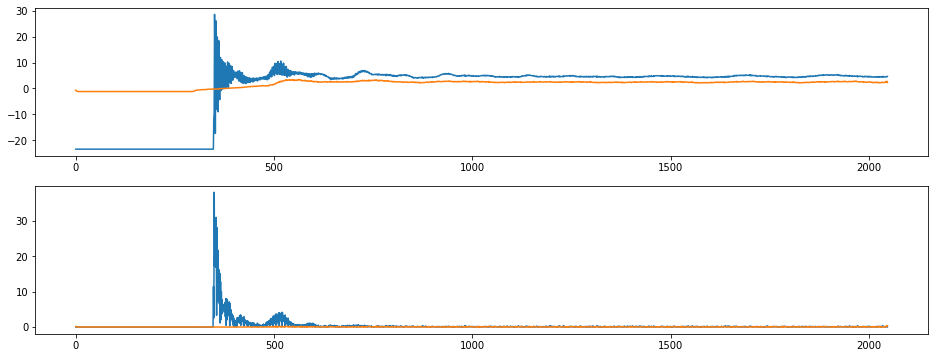

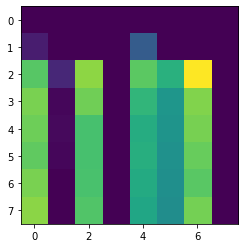

index:  162401
MAE:  5.886702524228602
n_bunches       1916
bunch_index     3378
bunch_number    1872
Name: 1653684, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_21h33m14s.h5


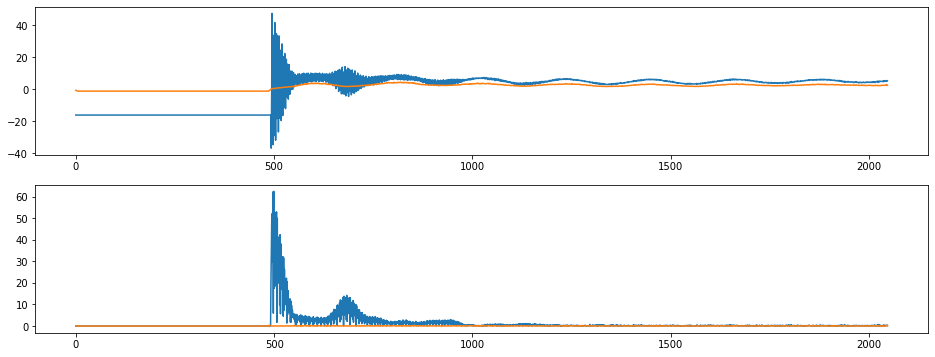

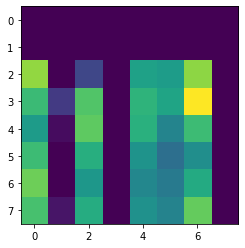

index:  78786
MAE:  5.885550656847481
n_bunches       410
bunch_index     336
bunch_number     73
Name: 9725228, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7306/instability_data/07306_Inst_B1H_Q7_20181015_06h35m08s.h5


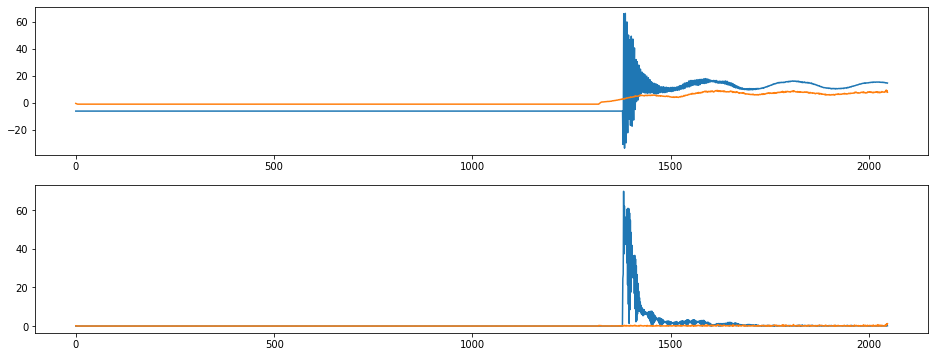

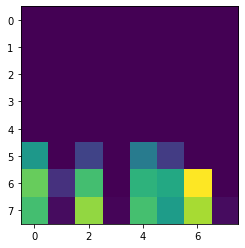

In [37]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [38]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [39]:
latent_metadata = pd.DataFrame(latent_metadata)

In [55]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [48]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [49]:
np.save(model_latent_space_file, latent_dataset)

In [50]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [51]:
np.save(model_train_dataset_file, train_dataset)

In [52]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [56]:
np.save(model_latent_input_file, latent_input_data)